# Predicting the Quality of Red Wine Using Machine Learning

### **Project Goal:**

To develop and evaluate machine learning models to accurately predict the quality of red wine based on its chemical properties. By analyzing the dataset and testing a range of classification algorithms, we aim to:

1. **Identify key factors influencing wine quality**: Gain insights into which chemical properties have the most significant impact on wine quality.
2. **Optimize predictive accuracy**: Compare the performance of various machine learning models to identify the algorithm that best generalizes on unseen data.
3. **Enhance decision-making**: Provide a reliable and interpretable framework that wine producers, distributors, and quality control teams can use to efficiently assess wine quality.

This project will demonstrate how machine learning can be leveraged to solve a real-world classification problem, highlighting both technical approaches and their practical applications in the wine industry.


### **About the Data**

The dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available.

### **Features and Descriptions**

| Variable Name | Role | Variable Type | Unit | Description |
| :- | :- | :- | :- | :- |
| fixed_acidity | Feature | Continuous | g(tartaric acid)/dm^3 | Concentration of fixed acids (e.g., tartaric acid) that do not evaporate easily and contribute to wine's taste and stability. | Concentration of volatile acids (e.g., acetic acid) that can evaporate and contribute to the wine's aroma and spoilage if excessive. |
| volatile_acidity | Feature | Continuous | g(acetic acid)/dm^3 | Concentration of volatile acids (e.g., acetic acid) that can evaporate and contribute to the wine's aroma and spoilage if excessive. |
| citric_acidity | Feature | Continuous | g/dm^3 | A weak acid naturally found in wine that can add freshness and enhance flavor. |
| residual_sugar | Feature | Continuous | g/dm^3 | The amount of sugar remaining after fermentation, affecting sweetness. Measured in grams per liter. |
| chlorides | Feature | Continuous | g(sodium chloride)/dm^3 | Concentration of salt in the wine, measured in grams per liter, contributing to its overall taste. |
| free_sulfur_dioxide | Feature | Continuous | mg/dm^3 | Part of the total sulfur dioxide content that protects the wine from oxidation and microbial spoilage. |
| total_sulfur_dioxide | Feature | Continuous | mg/dm^3 | The sum of all sulfur dioxide forms in the wine, impacting preservation and potential for off-flavors. |
| density | Feature | Continuous | g/cm^3 | The density of the wine, which can give insights into sugar and alcohol content. |
| pH | Feature | Continuous |  | Indicates the acidity level of the wine, affecting flavor and stability. | 
| sulphates | Feature | Continuous | g(potassium sulphate)/dm^3 | An additive that can increase a wine’s antioxidant capacity and contribute to its taste. |
| alcohol | Feature | Continuous | vol% | The alcohol content of the wine, measured as a percentage by volume. |
| quality | Target | Integer | score between 0 and 10 | A quality score (integer between 3 and 8) assigned by wine tasters. This is the target variable for wine quality prediction. |
| color | Feature | Categorical | red or white |  |


In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Load the data
df = pd.read_csv('winequality-red.csv')

In [6]:
# Inspect the first few rows
print(df.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [8]:
# Create a comprehensive summary table
summary_table = pd.DataFrame({
    "Column Name": df.columns,
    "count": df.count(),
    "dtype": df.dtypes.values,
    "nunique": df.nunique(),
    "%unique": (df.nunique() / len(df) * 100).round(2),
    "%null": (df.isnull().sum() / len(df) * 100).round(2),
    "min": df.min(),
    "max": df.max(),
    "correlation_with_quality": df.corr()["quality"].round(3) if "quality" in df.columns else np.nan,
    "outliers": (df.apply(zscore).abs() > 3).sum()
})

# Convert all values to strings to ensure consistent formatting
summary_table = summary_table.astype(str)

# Use tabulate to create a clean table
formatted_table = tabulate(
    summary_table,
    headers="keys",
    tablefmt="pipe",
    showindex=False
)

# Print the table
print(formatted_table)


| Column Name          |   count | dtype   |   nunique |   %unique |   %null |     min |       max |   correlation_with_quality |   outliers |
|:---------------------|--------:|:--------|----------:|----------:|--------:|--------:|----------:|---------------------------:|-----------:|
| fixed acidity        |    1599 | float64 |        96 |      6    |       0 | 4.6     |  15.9     |                      0.124 |         12 |
| volatile acidity     |    1599 | float64 |       143 |      8.94 |       0 | 0.12    |   1.58    |                     -0.391 |         10 |
| citric acid          |    1599 | float64 |        80 |      5    |       0 | 0       |   1       |                      0.226 |          1 |
| residual sugar       |    1599 | float64 |        91 |      5.69 |       0 | 0.9     |  15.5     |                      0.014 |         30 |
| chlorides            |    1599 | float64 |       153 |      9.57 |       0 | 0.012   |   0.611   |                     -0.129 |         31 |

In [10]:
# Check for Duplicates
df.duplicated().sum()

240

In [12]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [14]:
df.shape

(1359, 12)

### Step 1: General Exploratory Data Analysis

In this step, we perform a general exploratory analysis of the dataset to understand its structure, distributions, and overall characteristics. This includes examining:
- Data types and unique values.
- Missing values.
- Distributions (via histograms).
- Outliers (via boxplots).

The goal is to gain a broad understanding of the dataset before diving into specific relationships.


In [17]:
def perform_eda(df, target=None):
    """
    Perform EDA on each column of the dataframe.

    Args:
    df (DataFrame): The dataset.
    target (str): The target variable (optional).

    Returns:
    None: Displays visualizations and statistics for each column.
    """
    for col in df.columns:
        print(f"\n{'='*50}\nExploring Column: {col}\n{'='*50}")
        
        # 1. Descriptive Statistics
        print(f"Data Type: {df[col].dtype}")
        print(f"Unique Values: {df[col].nunique()} ({(df[col].nunique() / len(df) * 100):.2f}% unique)")
        print(f"Missing Values: {df[col].isnull().sum()} ({(df[col].isnull().mean() * 100):.2f}%)")
        if df[col].dtype != 'object':
            print(df[col].describe())

        # 2. Visualizations
        plt.figure(figsize=(10, 6))
        if df[col].dtype != 'object':
            # Numeric Columns
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()
            
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            plt.xlabel(col)
            plt.show()
        else:
            # Categorical Columns
            value_counts = df[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Frequency Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.show()

        # 3. Correlation with Target (if provided and column is numeric)
        if target and df[col].dtype != 'object' and df[target].dtype != 'object':
            correlation = df[col].corr(df[target])
            print(f"Correlation with Target ({target}): {correlation:.3f}")
            sns.scatterplot(x=df[col], y=df[target])
            plt.title(f'{col} vs {target}')
            plt.xlabel(col)
            plt.ylabel(target)
            plt.show()



Exploring Column: fixed acidity
Data Type: float64
Unique Values: 96 (7.06% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        8.310596
std         1.736990
min         4.600000
25%         7.100000
50%         7.900000
75%         9.200000
max        15.900000
Name: fixed acidity, dtype: float64


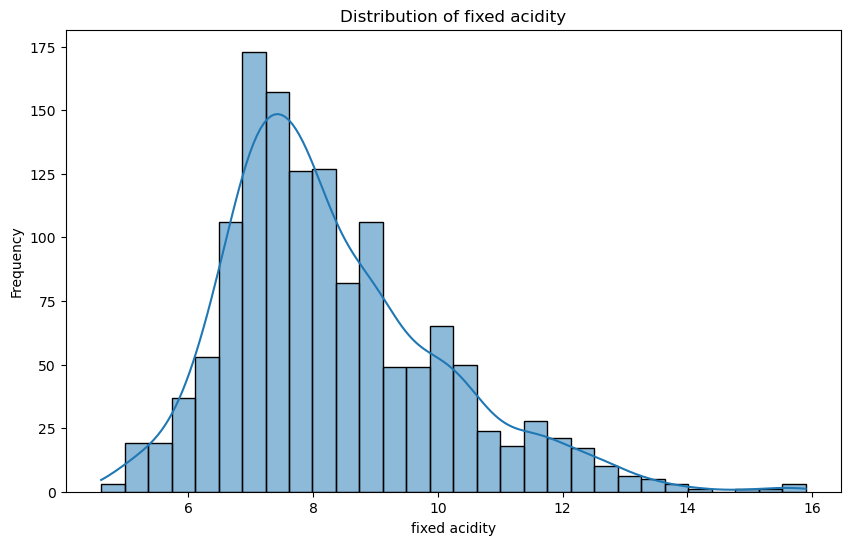

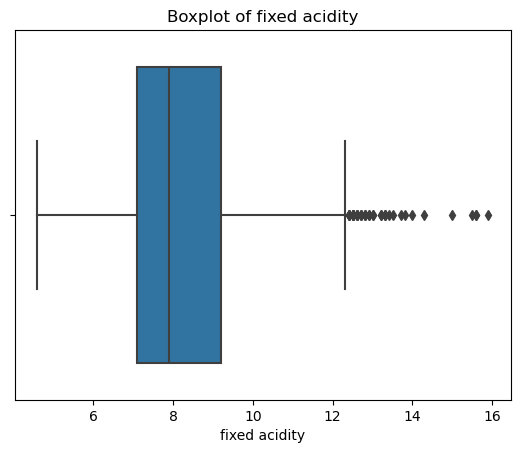

Correlation with Target (quality): 0.119


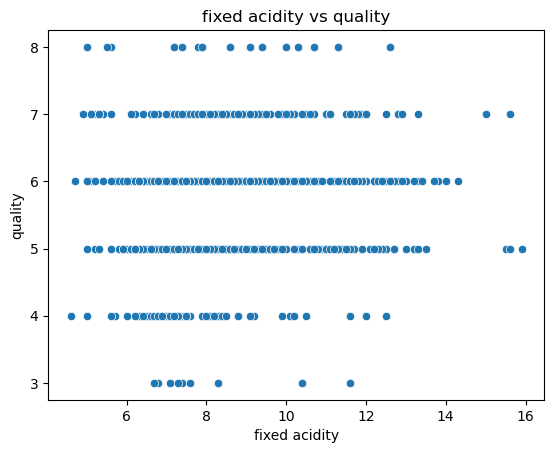


Exploring Column: volatile acidity
Data Type: float64
Unique Values: 143 (10.52% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        0.529478
std         0.183031
min         0.120000
25%         0.390000
50%         0.520000
75%         0.640000
max         1.580000
Name: volatile acidity, dtype: float64


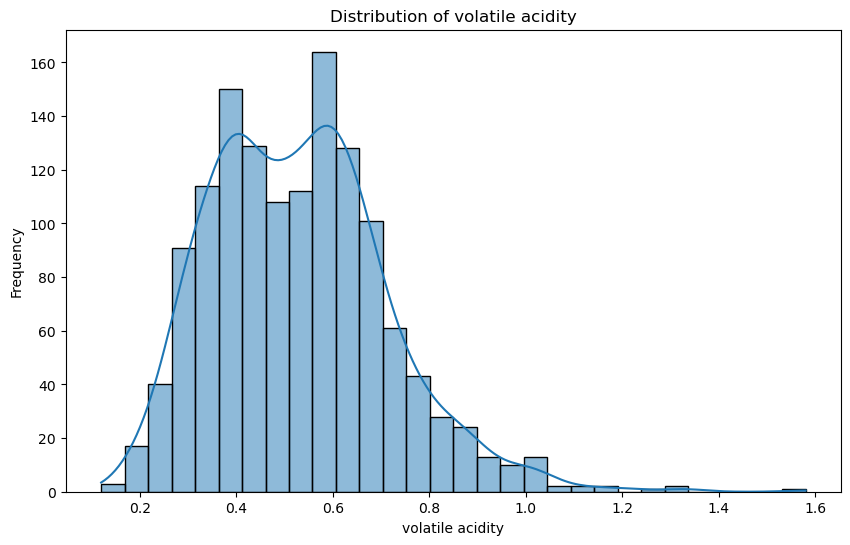

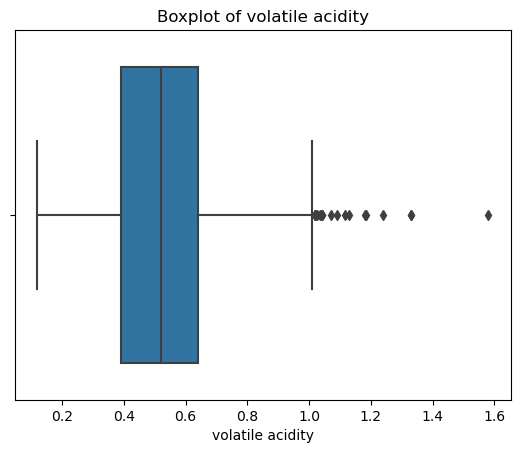

Correlation with Target (quality): -0.395


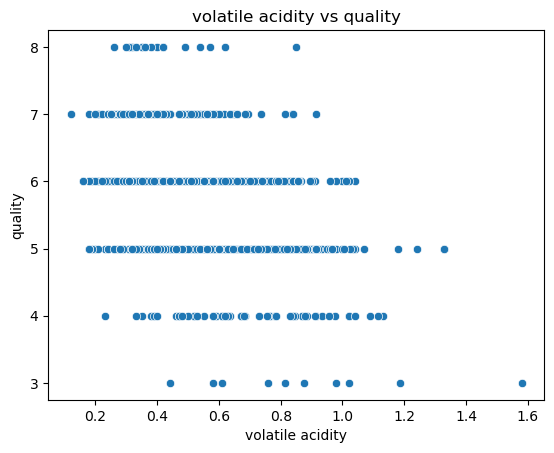


Exploring Column: citric acid
Data Type: float64
Unique Values: 80 (5.89% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        0.272333
std         0.195537
min         0.000000
25%         0.090000
50%         0.260000
75%         0.430000
max         1.000000
Name: citric acid, dtype: float64


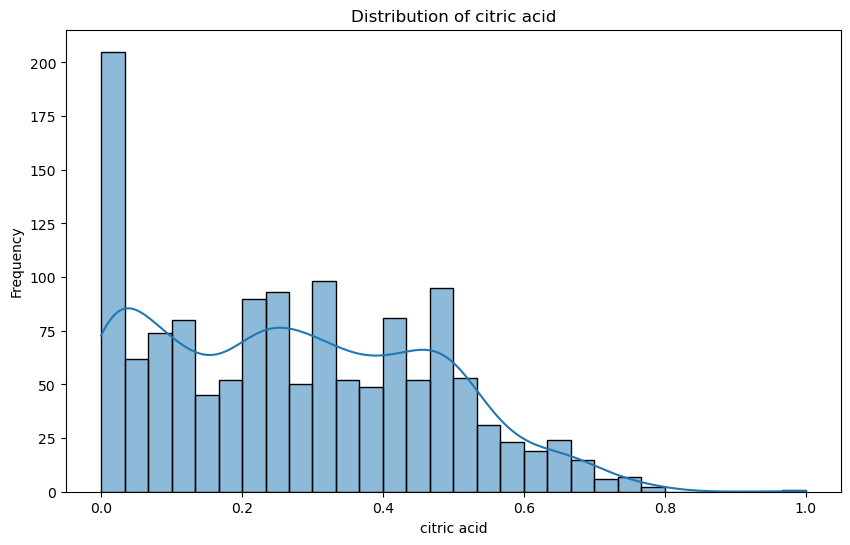

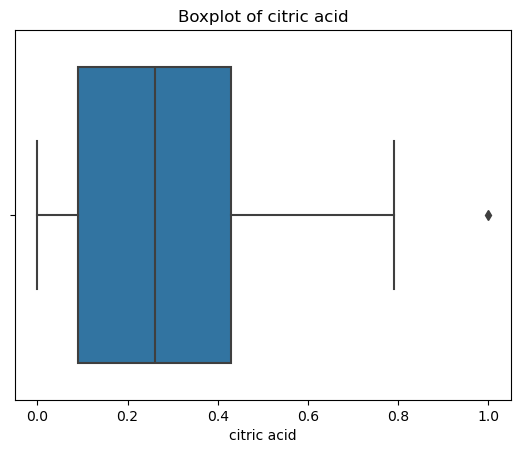

Correlation with Target (quality): 0.228


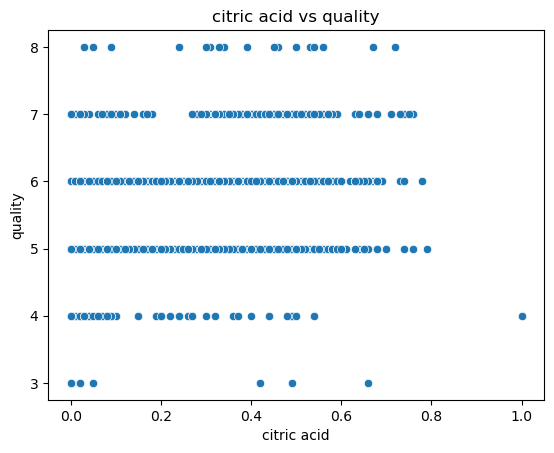


Exploring Column: residual sugar
Data Type: float64
Unique Values: 91 (6.70% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        2.523400
std         1.352314
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64


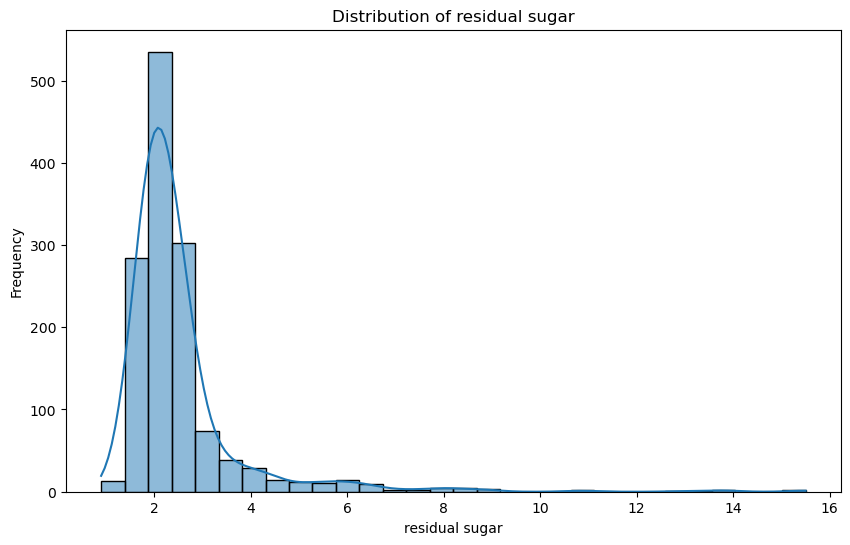

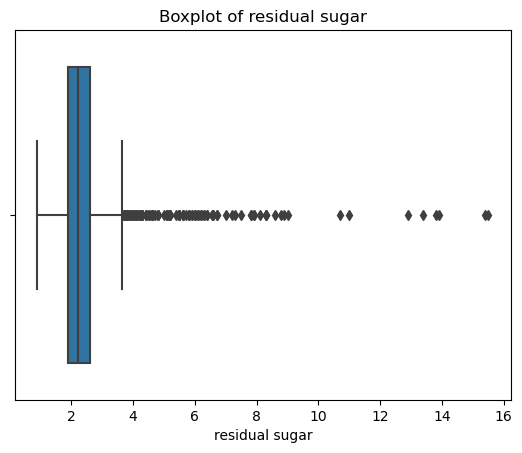

Correlation with Target (quality): 0.014


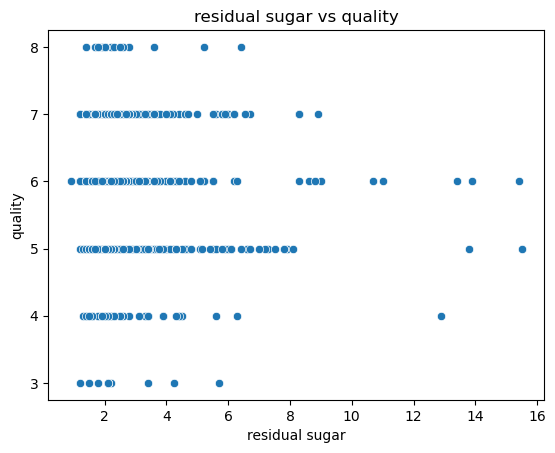


Exploring Column: chlorides
Data Type: float64
Unique Values: 153 (11.26% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        0.088124
std         0.049377
min         0.012000
25%         0.070000
50%         0.079000
75%         0.091000
max         0.611000
Name: chlorides, dtype: float64


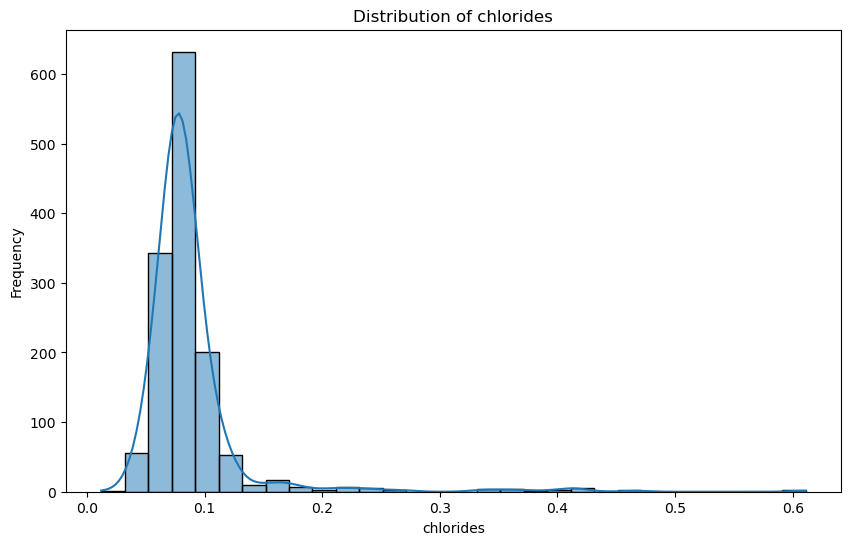

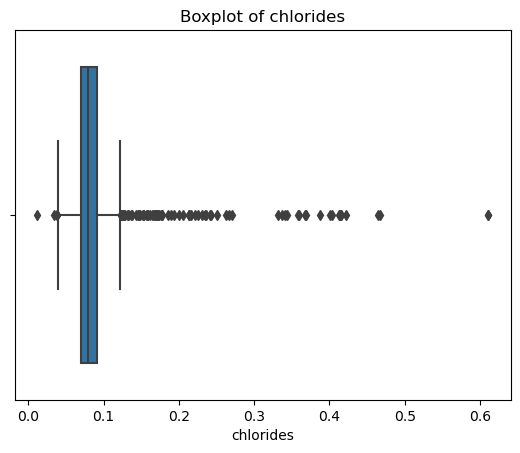

Correlation with Target (quality): -0.131


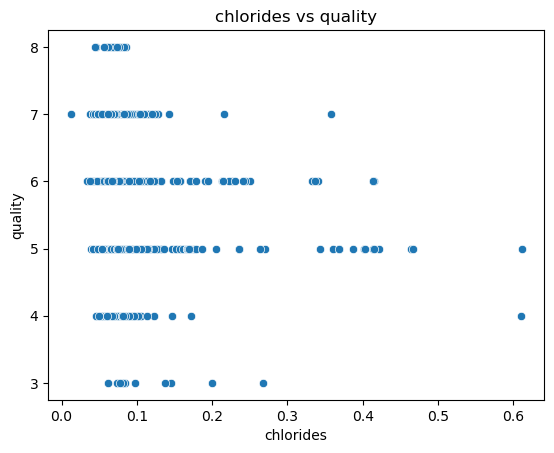


Exploring Column: free sulfur dioxide
Data Type: float64
Unique Values: 60 (4.42% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean       15.893304
std        10.447270
min         1.000000
25%         7.000000
50%        14.000000
75%        21.000000
max        72.000000
Name: free sulfur dioxide, dtype: float64


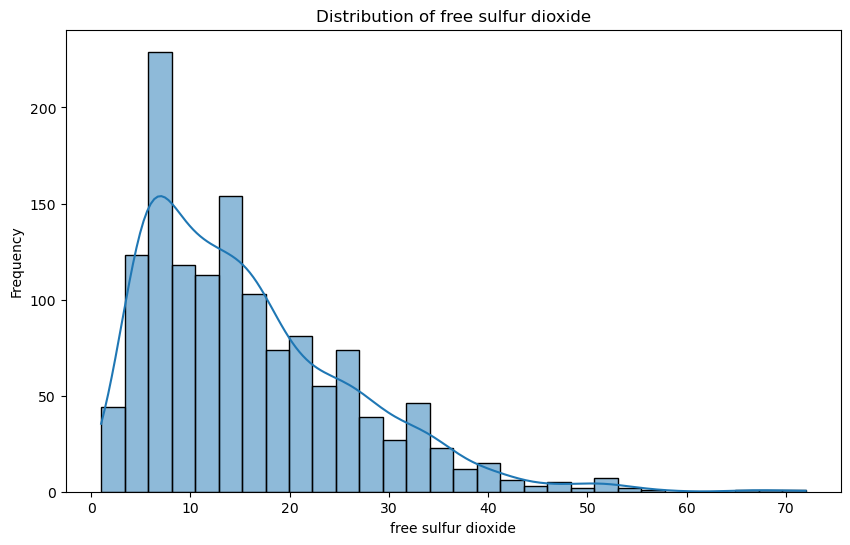

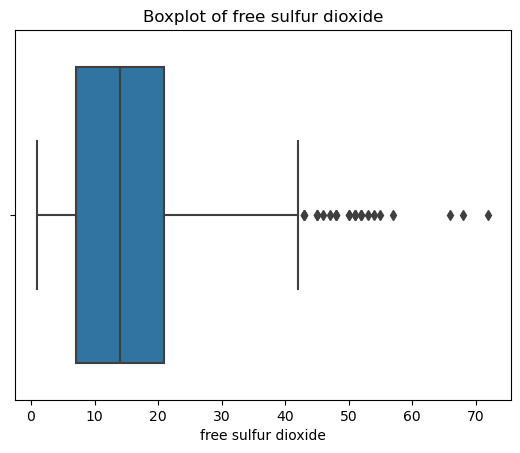

Correlation with Target (quality): -0.050


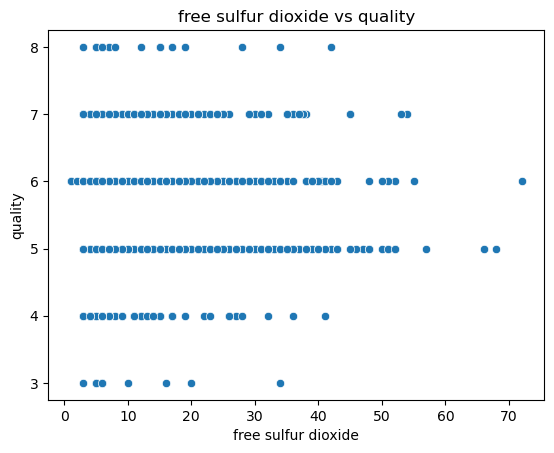


Exploring Column: total sulfur dioxide
Data Type: float64
Unique Values: 144 (10.60% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean       46.825975
std        33.408946
min         6.000000
25%        22.000000
50%        38.000000
75%        63.000000
max       289.000000
Name: total sulfur dioxide, dtype: float64


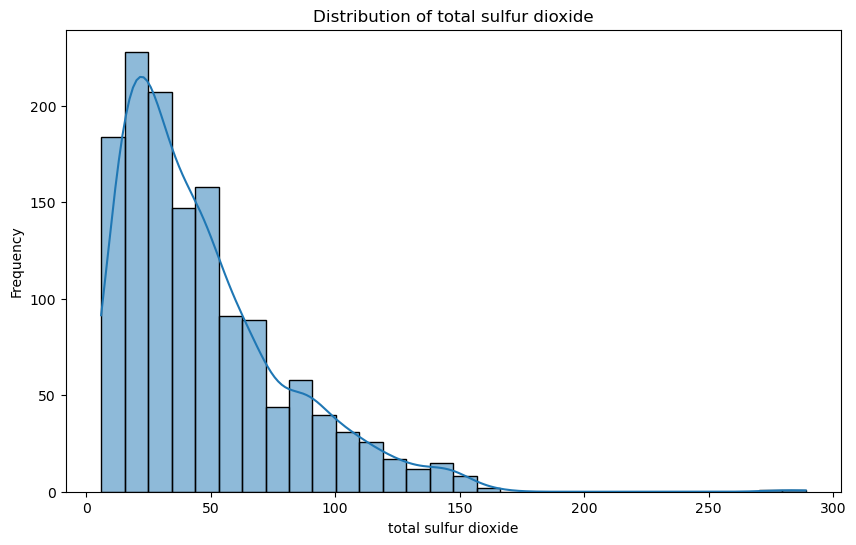

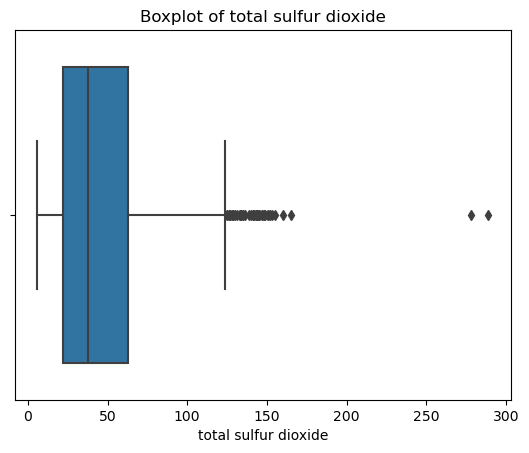

Correlation with Target (quality): -0.178


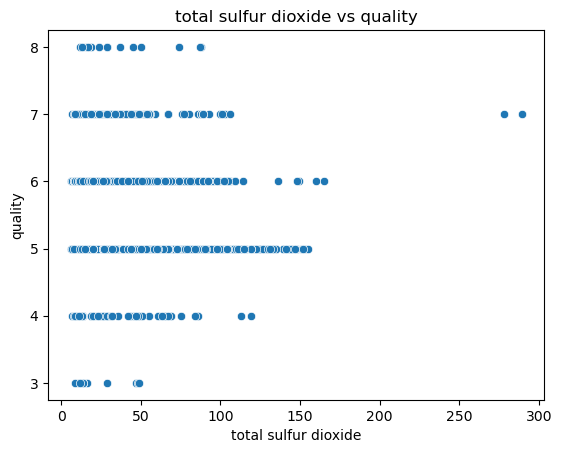


Exploring Column: density
Data Type: float64
Unique Values: 436 (32.08% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        0.996709
std         0.001869
min         0.990070
25%         0.995600
50%         0.996700
75%         0.997820
max         1.003690
Name: density, dtype: float64


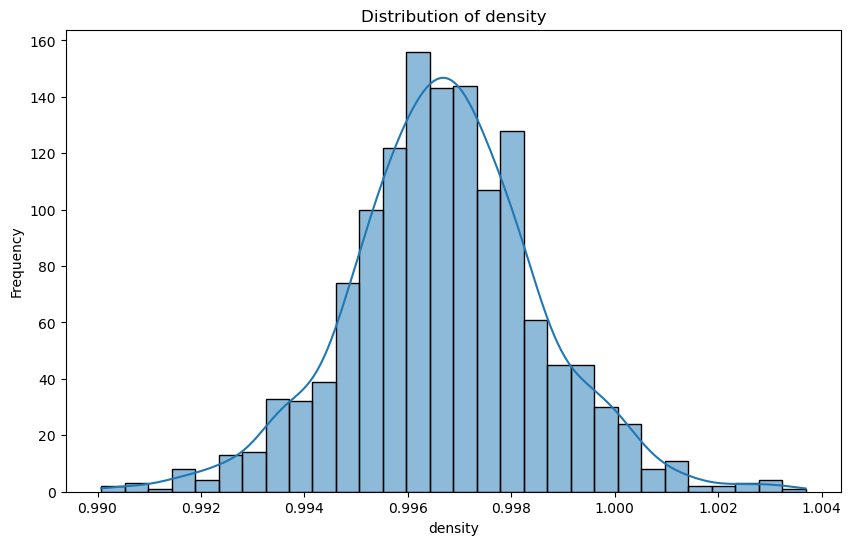

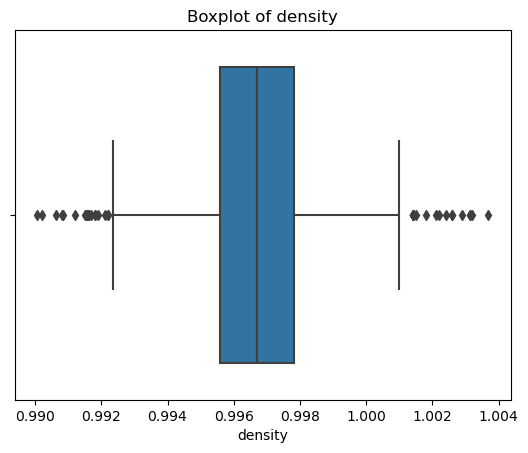

Correlation with Target (quality): -0.184


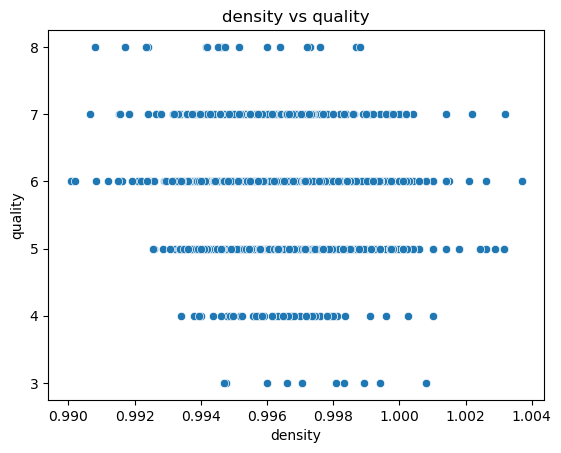


Exploring Column: pH
Data Type: float64
Unique Values: 89 (6.55% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        3.309787
std         0.155036
min         2.740000
25%         3.210000
50%         3.310000
75%         3.400000
max         4.010000
Name: pH, dtype: float64


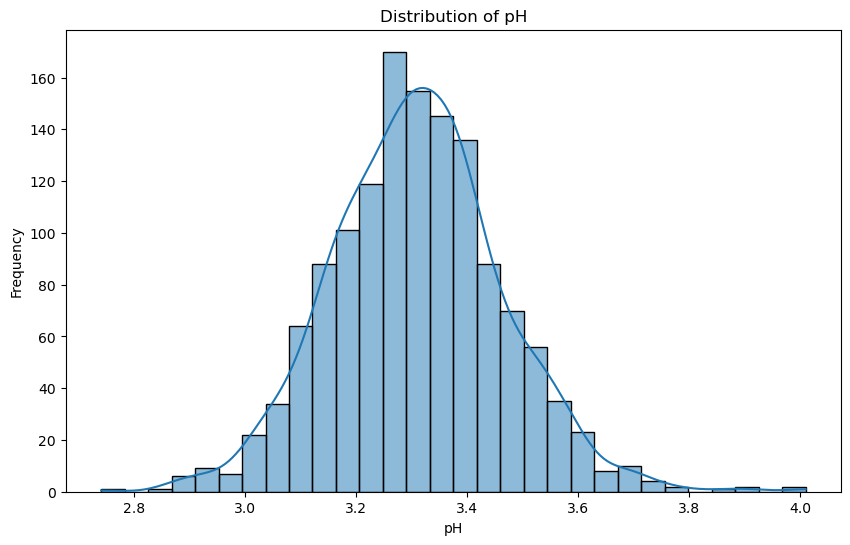

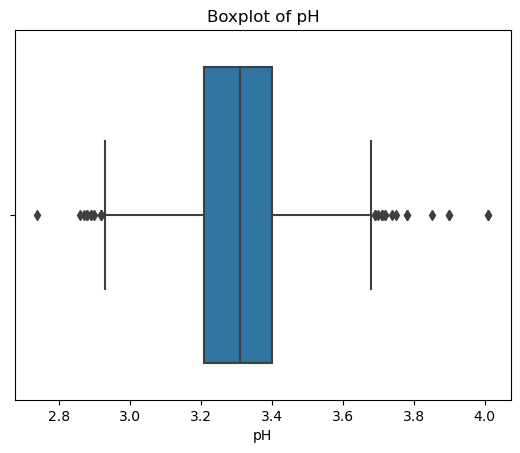

Correlation with Target (quality): -0.055


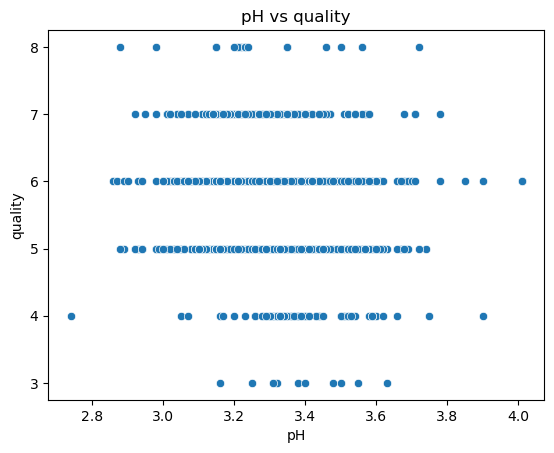


Exploring Column: sulphates
Data Type: float64
Unique Values: 96 (7.06% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        0.658705
std         0.170667
min         0.330000
25%         0.550000
50%         0.620000
75%         0.730000
max         2.000000
Name: sulphates, dtype: float64


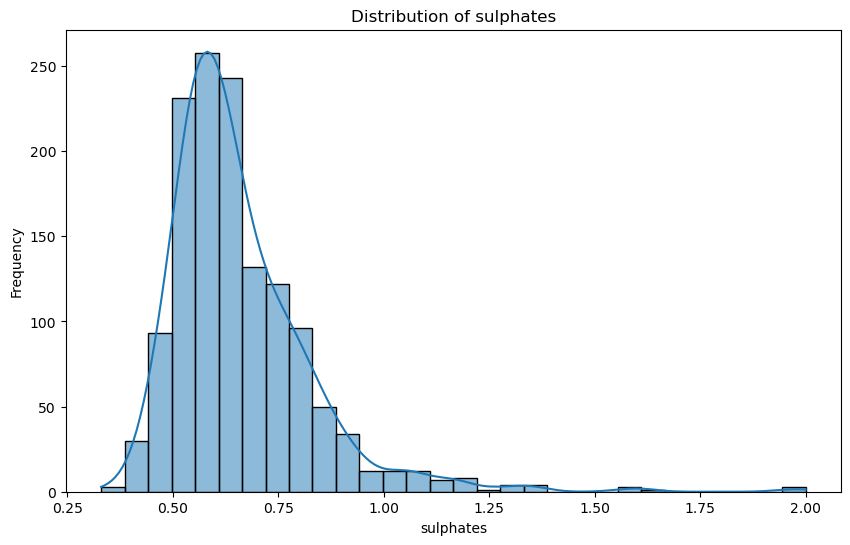

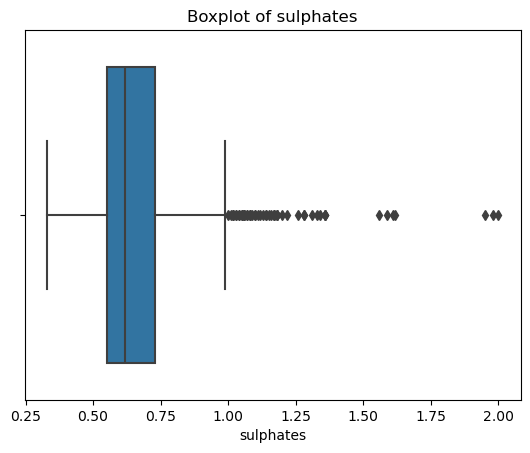

Correlation with Target (quality): 0.249


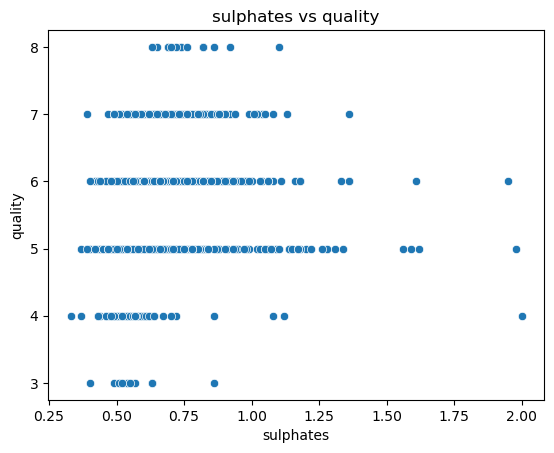


Exploring Column: alcohol
Data Type: float64
Unique Values: 65 (4.78% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean       10.432315
std         1.082065
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64


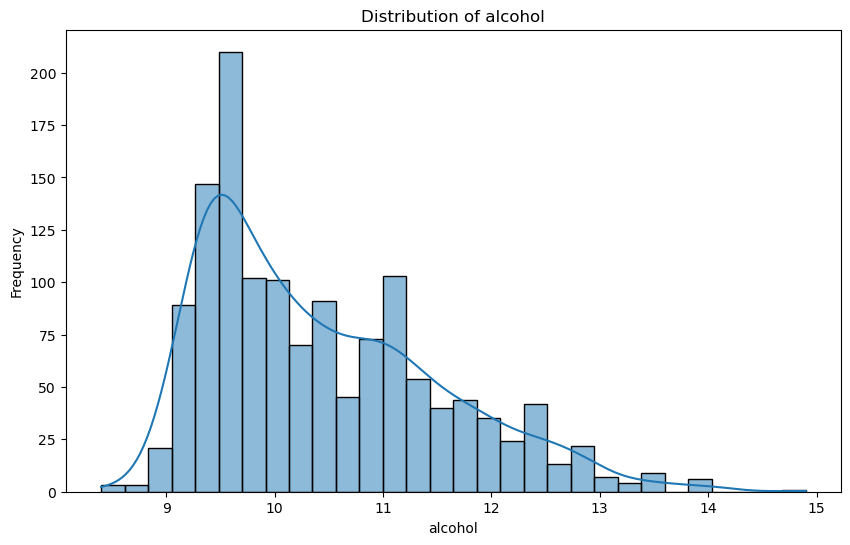

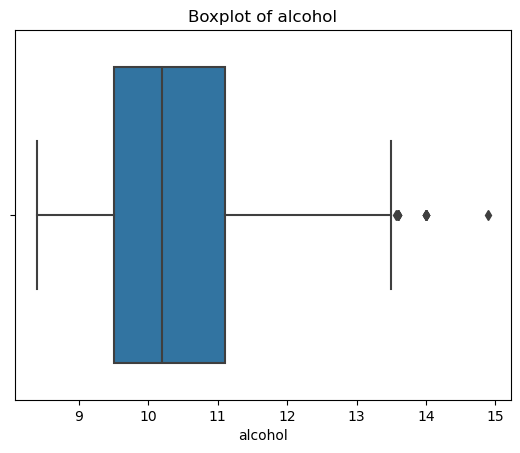

Correlation with Target (quality): 0.480


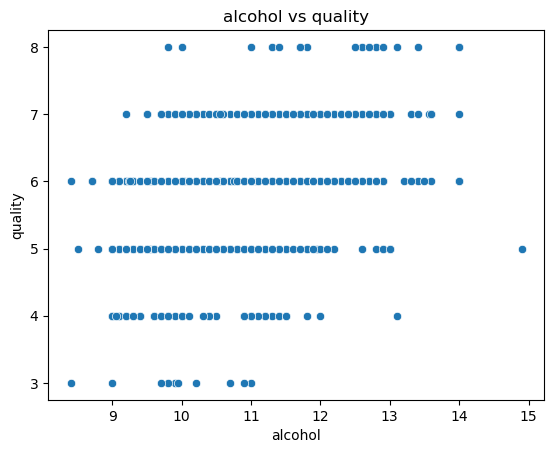


Exploring Column: quality
Data Type: int64
Unique Values: 6 (0.44% unique)
Missing Values: 0 (0.00%)
count    1359.000000
mean        5.623252
std         0.823578
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64


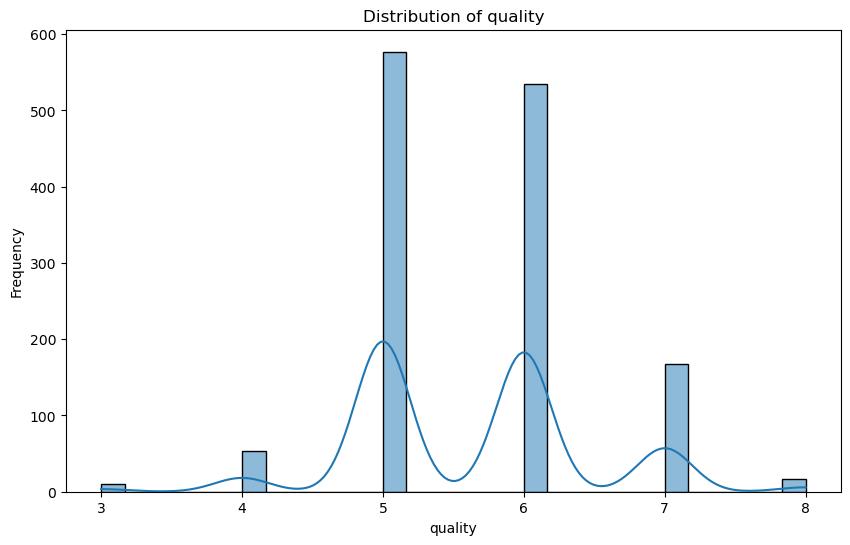

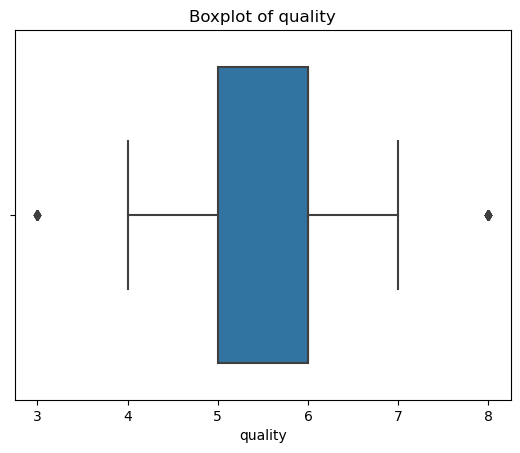

Correlation with Target (quality): 1.000


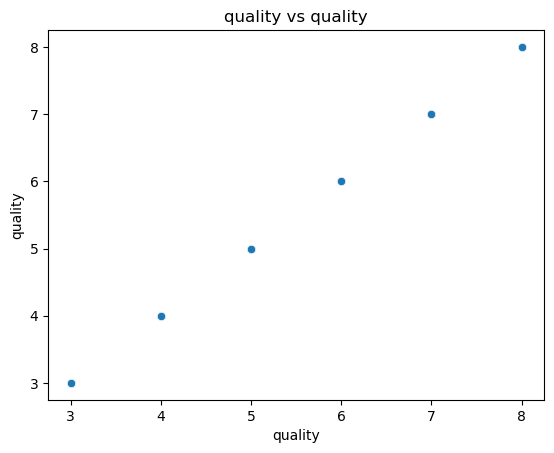

In [19]:
# Perform EDA on the dataset
perform_eda(df, target="quality")


### General EDA Summary

We conducted general exploratory data analysis to understand the distribution and characteristics of the features. Key visualizations such as histograms and boxplots are included to highlight potential outliers and distribution patterns for each feature.


### Step 2: Exploring Feature Relationships with Quality

Here, we analyze how each feature relates to the target variable (`quality`). This step includes:
- Calculating correlations between numeric features and `quality`.
- Visualizing distributions grouped by `quality` using boxplots.
- For categorical features, observing mean `quality` for each group.

The goal is to identify which features have the strongest relationships with wine quality, providing insights for predictive modeling.


In [23]:
def perform_eda_with_quality(df, target="quality"):
    """
    Perform EDA for each column and compare it to the target variable.

    Args:
    df (DataFrame): The dataset.
    target (str): The target variable (default is 'quality').

    Returns:
    None: Displays visualizations for each column compared to the target variable.
    """
    for col in df.columns:
        if col == target:
            continue  # Skip the target column itself

        print(f"\n{'='*50}\nExploring Column: {col} vs {target}\n{'='*50}")

        # 1. Descriptive Statistics
        print(f"Data Type: {df[col].dtype}")
        print(f"Unique Values: {df[col].nunique()} ({(df[col].nunique() / len(df) * 100):.2f}% unique)")
        print(f"Missing Values: {df[col].isnull().sum()} ({(df[col].isnull().mean() * 100):.2f}%)")

        # 2. Visualization: Numeric Columns
        if df[col].dtype != 'object':
            # Boxplot: Compare distributions of the column across quality levels
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=df[target], y=df[col], palette="viridis")
            plt.title(f'{col} Distribution by {target}')
            plt.xlabel(target)
            plt.ylabel(col)
            plt.show()

            # Scatterplot: Show relationship between column and quality
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=df[col], y=df[target], alpha=0.6, hue=df[target], palette="viridis")
            plt.title(f'{col} vs {target}')
            plt.xlabel(col)
            plt.ylabel(target)
            plt.show()

        # 3. Visualization: Categorical Columns
        else:
            # Barplot: Show mean of target for each category
            plt.figure(figsize=(10, 6))
            sns.barplot(x=df[col], y=df[target], palette="viridis", ci=None)
            plt.title(f'{col} vs Mean {target}')
            plt.xlabel(col)
            plt.ylabel(f'Mean {target}')
            plt.xticks(rotation=45)
            plt.show()

            # Countplot: Show the frequency distribution by quality
            plt.figure(figsize=(10, 6))
            sns.countplot(x=col, hue=target, data=df, palette="viridis")
            plt.title(f'{col} Distribution by {target}')
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()



Exploring Column: fixed acidity vs quality
Data Type: float64
Unique Values: 96 (7.06% unique)
Missing Values: 0 (0.00%)


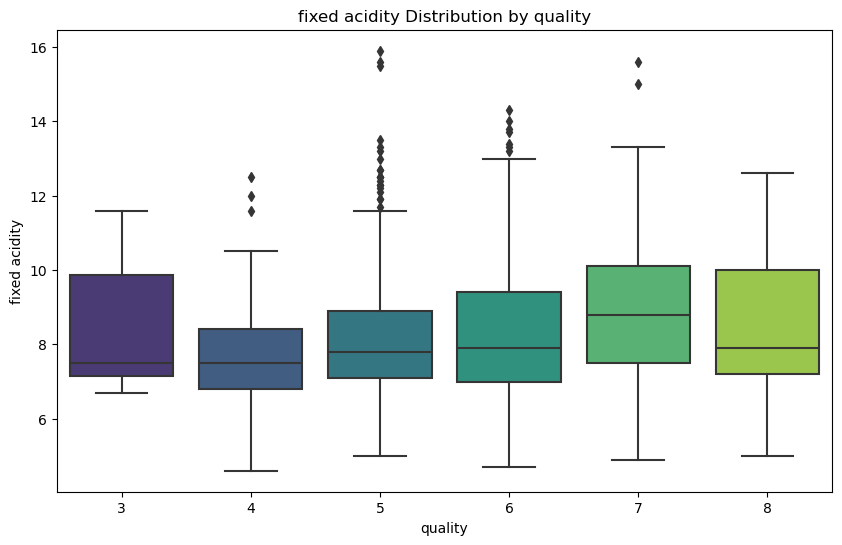

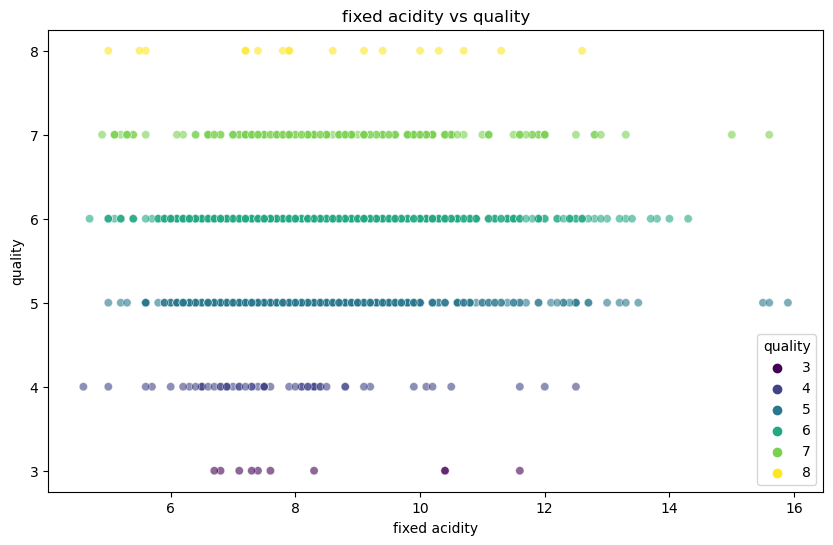


Exploring Column: volatile acidity vs quality
Data Type: float64
Unique Values: 143 (10.52% unique)
Missing Values: 0 (0.00%)


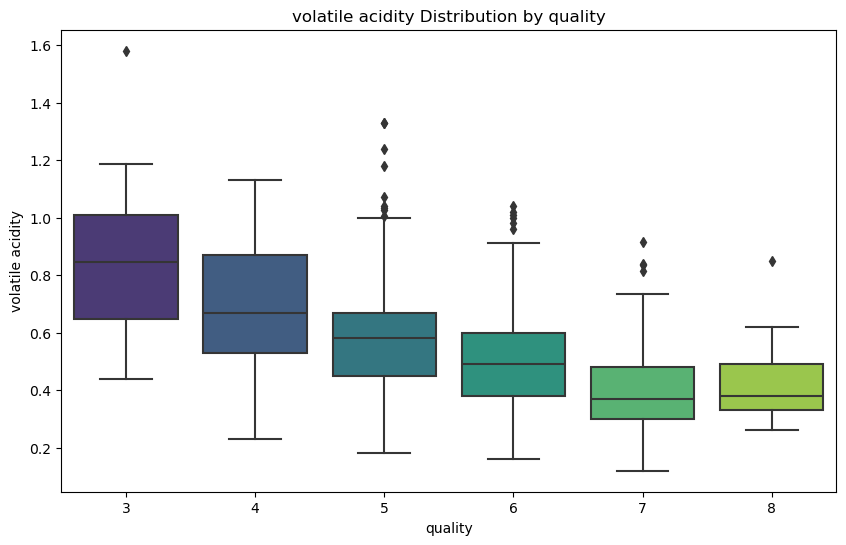

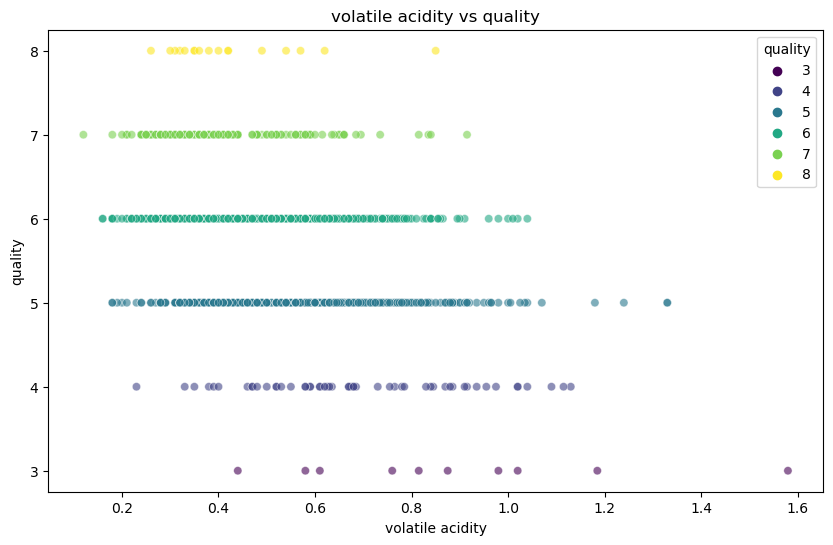


Exploring Column: citric acid vs quality
Data Type: float64
Unique Values: 80 (5.89% unique)
Missing Values: 0 (0.00%)


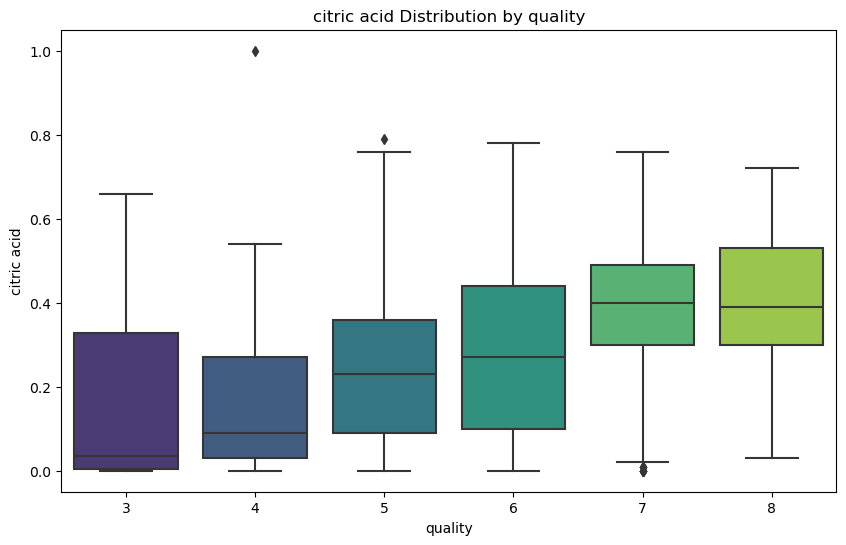

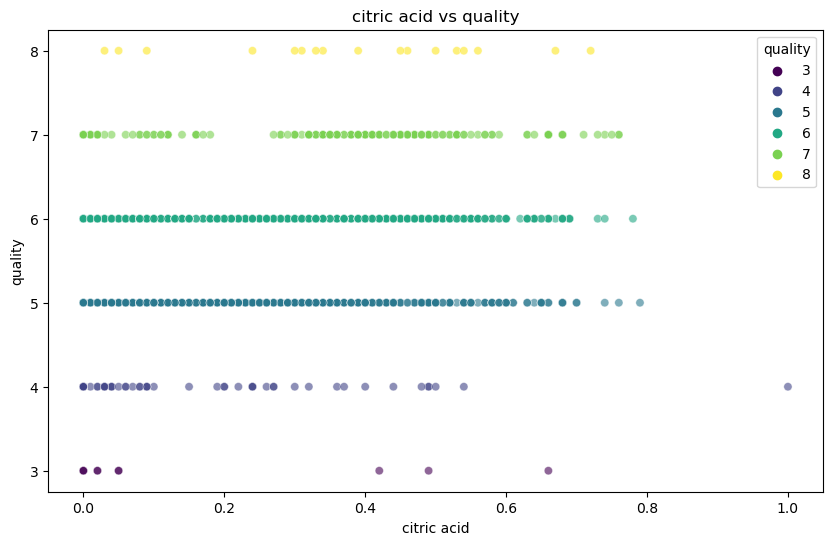


Exploring Column: residual sugar vs quality
Data Type: float64
Unique Values: 91 (6.70% unique)
Missing Values: 0 (0.00%)


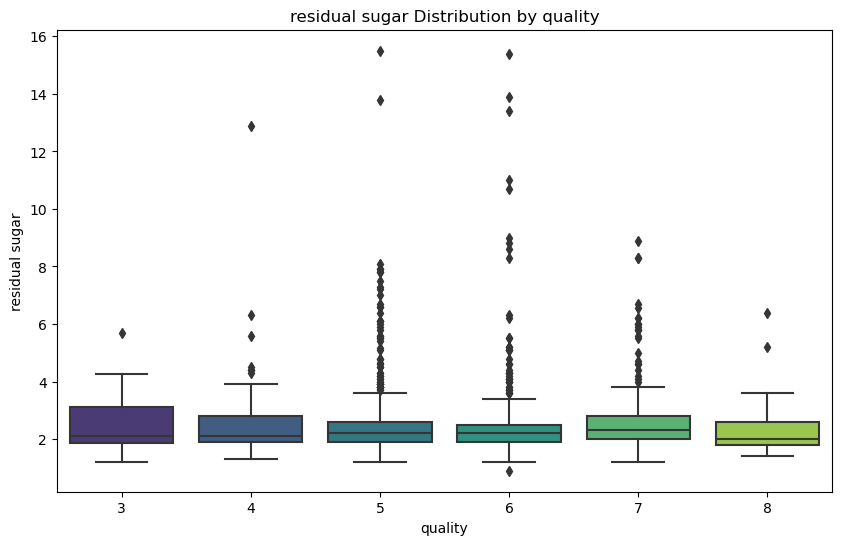

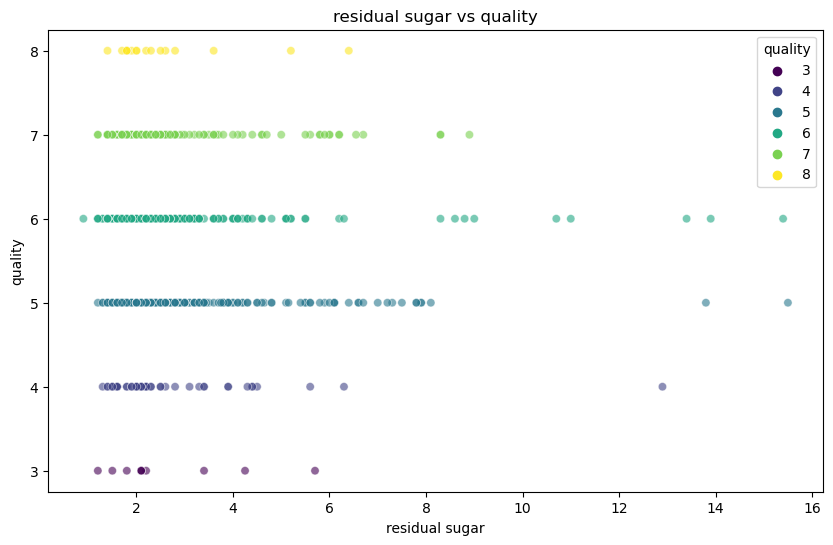


Exploring Column: chlorides vs quality
Data Type: float64
Unique Values: 153 (11.26% unique)
Missing Values: 0 (0.00%)


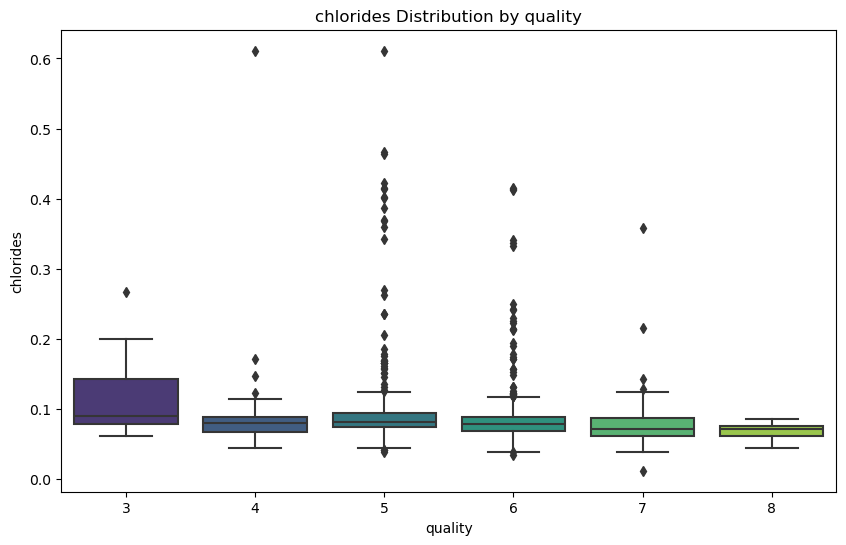

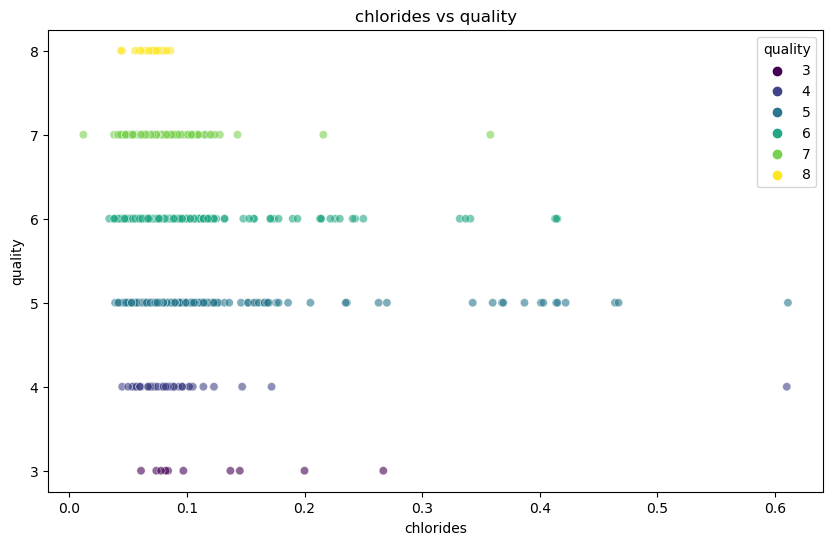


Exploring Column: free sulfur dioxide vs quality
Data Type: float64
Unique Values: 60 (4.42% unique)
Missing Values: 0 (0.00%)


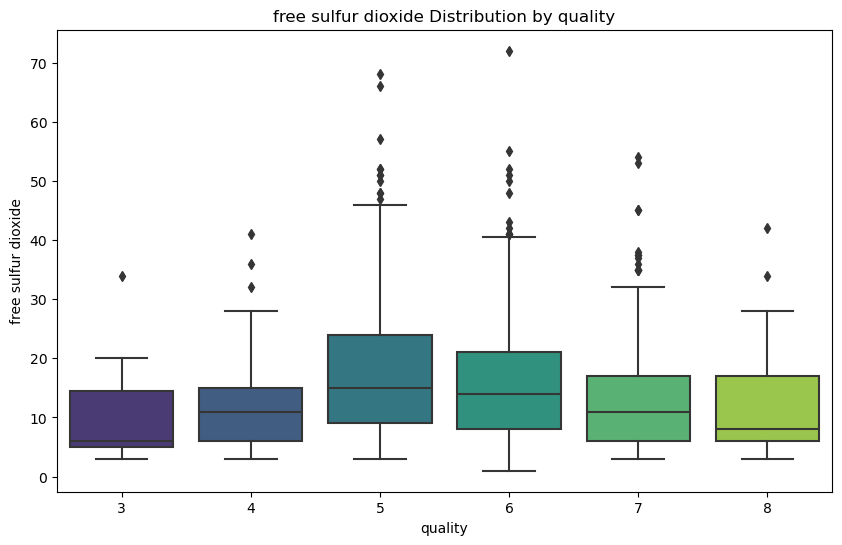

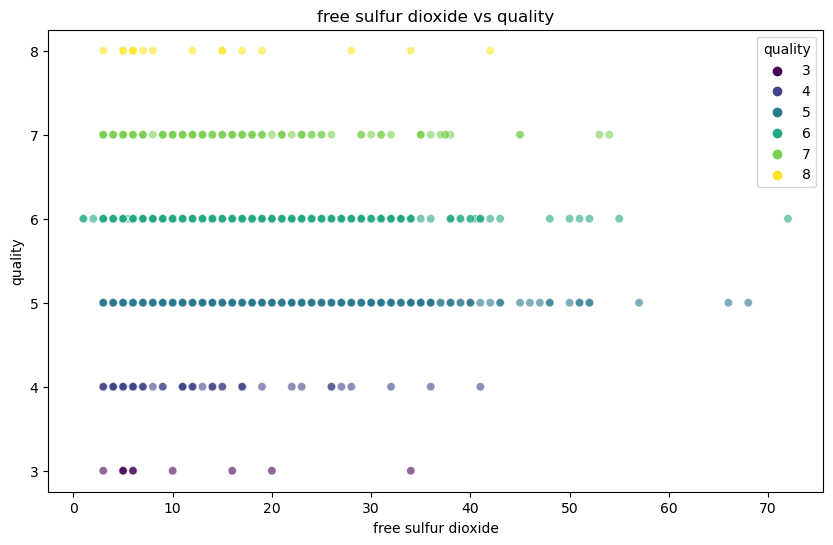


Exploring Column: total sulfur dioxide vs quality
Data Type: float64
Unique Values: 144 (10.60% unique)
Missing Values: 0 (0.00%)


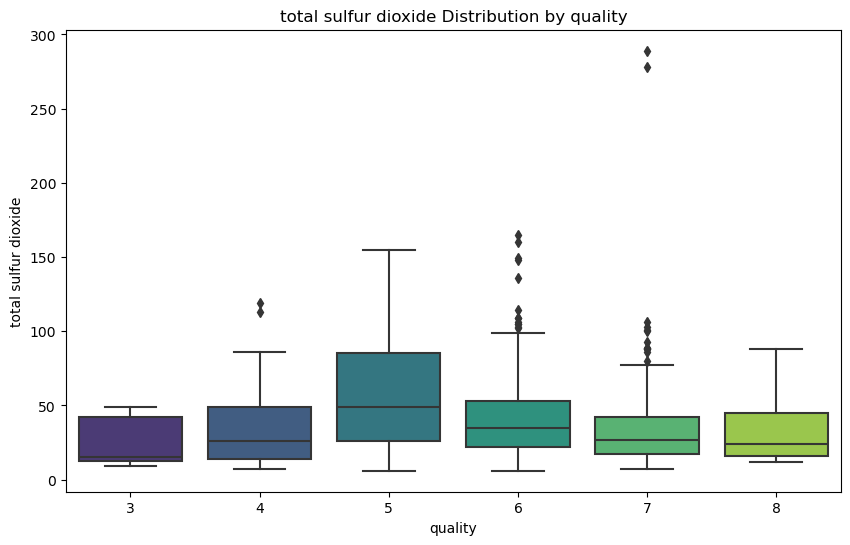

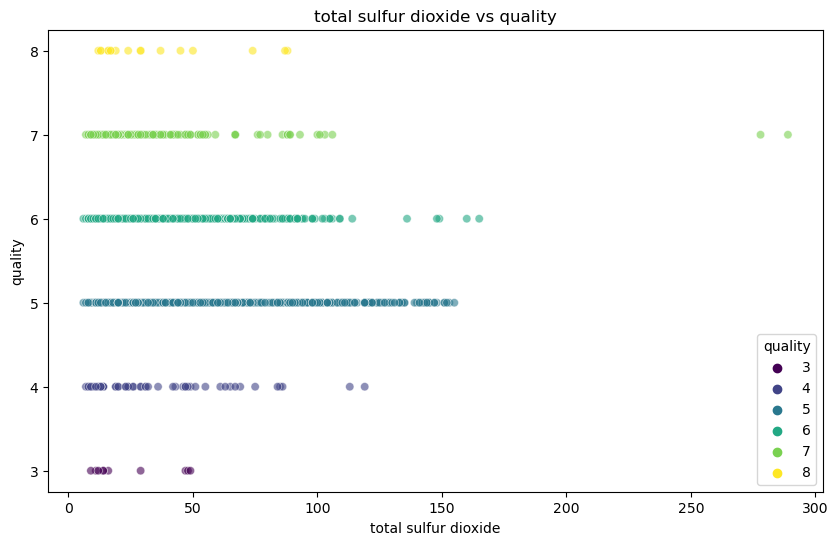


Exploring Column: density vs quality
Data Type: float64
Unique Values: 436 (32.08% unique)
Missing Values: 0 (0.00%)


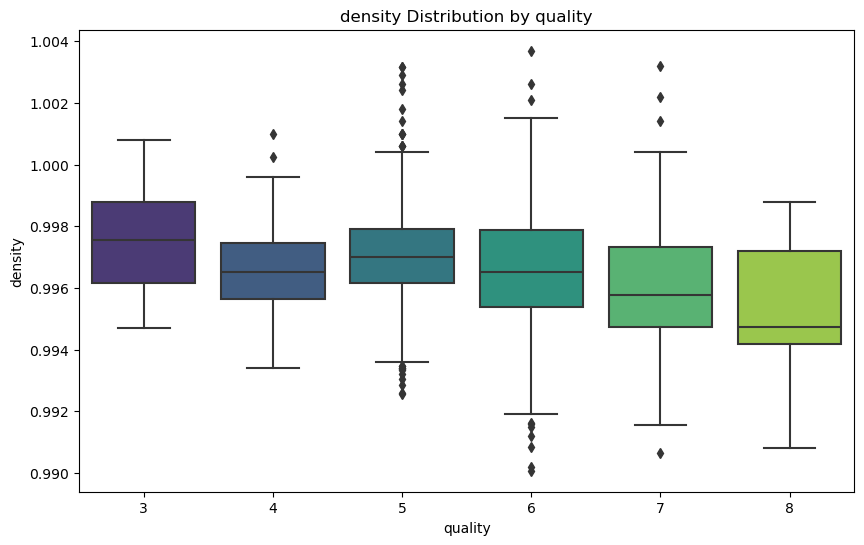

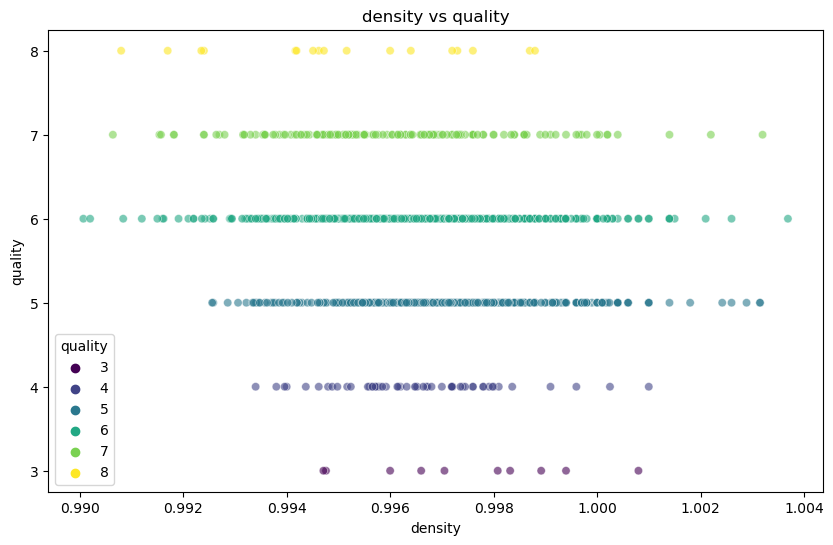


Exploring Column: pH vs quality
Data Type: float64
Unique Values: 89 (6.55% unique)
Missing Values: 0 (0.00%)


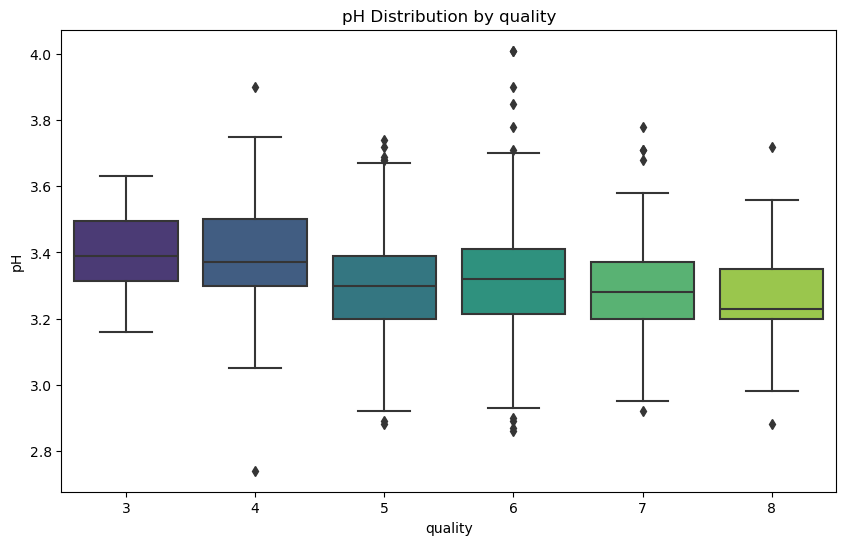

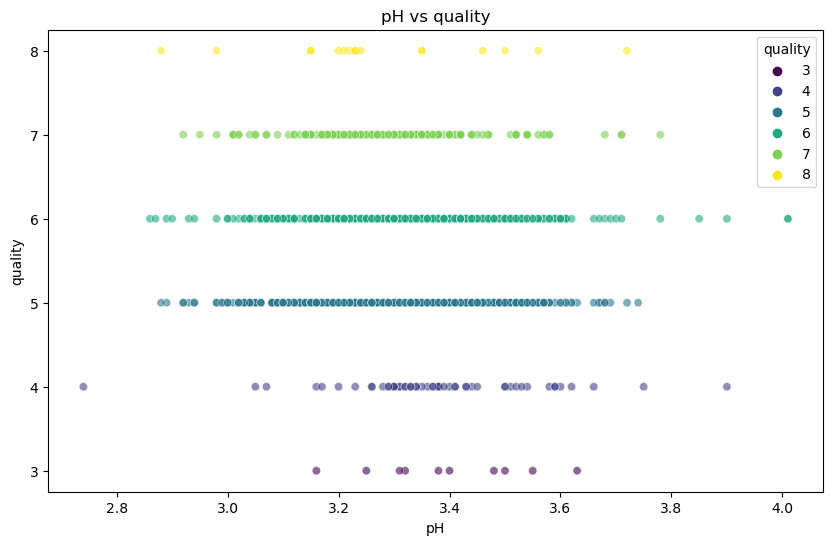


Exploring Column: sulphates vs quality
Data Type: float64
Unique Values: 96 (7.06% unique)
Missing Values: 0 (0.00%)


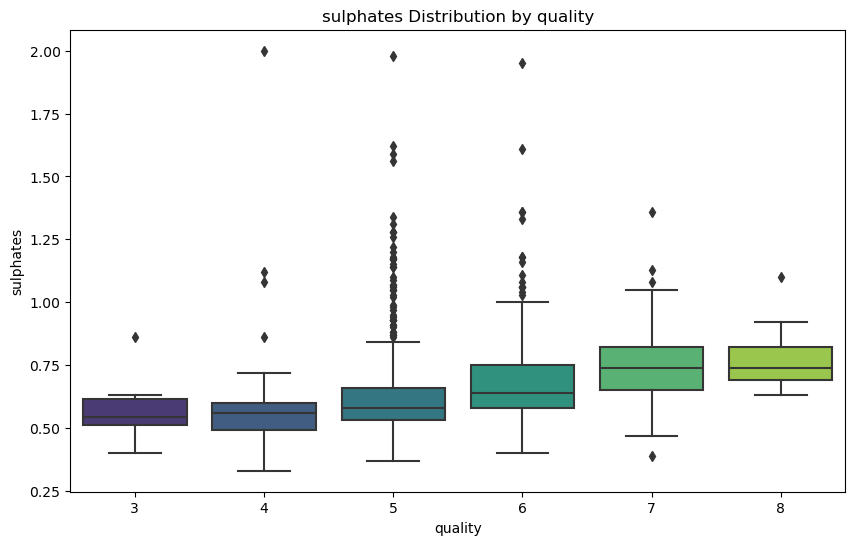

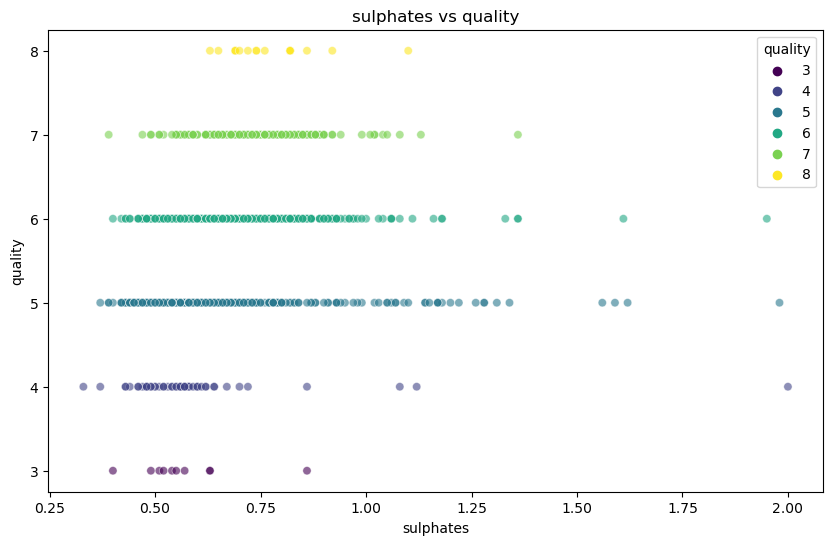


Exploring Column: alcohol vs quality
Data Type: float64
Unique Values: 65 (4.78% unique)
Missing Values: 0 (0.00%)


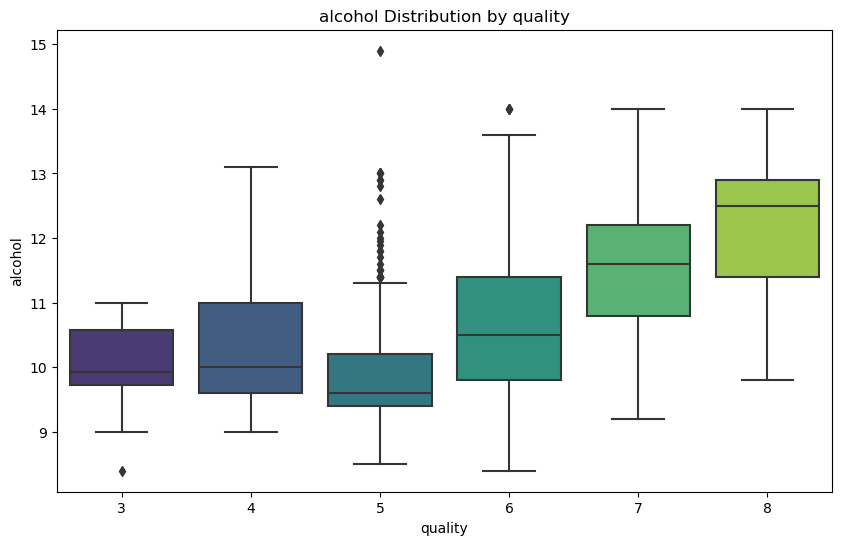

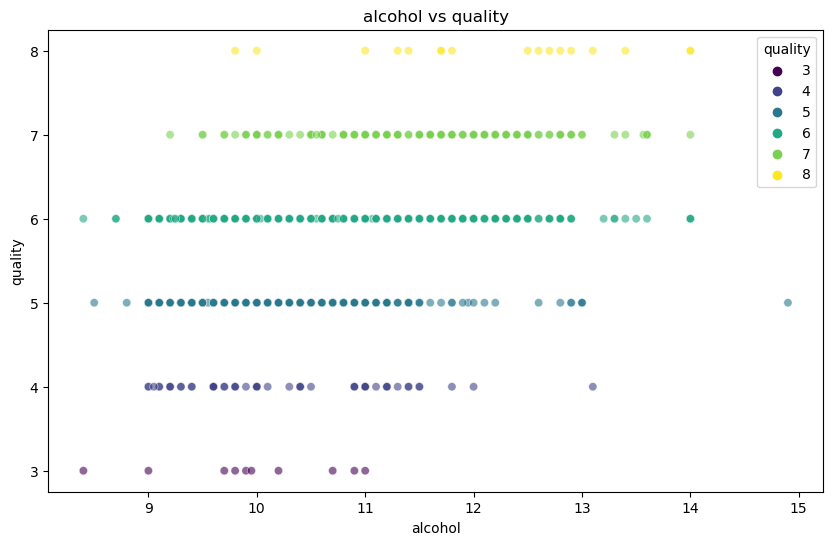

In [25]:
# Perform EDA on the dataset
perform_eda_with_quality(df, target="quality")

### EDA with Quality Analysis

- **fixed acidity**: Shows a weak positive correlation with `quality` (correlation coefficient: 0.124).
- **volatile acidity**: Shows a strong negative correlation with `quality` (correlation coefficient: -0.391).
- **citric acid**: Shows a moderate positive correlation with `quality` (correlation coefficient: 0.226).
- **residual sugar**: Shows a very weak positive correlation with `quality` (correlation coefficient: 0.014).
- **chlorides**: Shows a weak negative correlation with `quality` (correlation coefficient: -0.129).
- **free sulfur dioxide**: Shows a very weak negative correlation with `quality` (correlation coefficient: -0.051).
- **total sulfur dioxide**: Shows a weak negative correlation with `quality` (correlation coefficient: -0.185).
- **density**: Shows a weak negative correlation with `quality` (correlation coefficient: -0.175).
- **pH**: Shows a very weak negative correlation with `quality` (correlation coefficient: -0.058).
- **sulphates**: Shows a moderate positive correlation with `quality` (correlation coefficient: 0.251).
- **alcohol**: Shows a strong positive correlation with `quality` (correlation coefficient: 0.476).


### Step 3: Heatmap of Correlations

To summarize feature relationships, we generate a heatmap of correlations. This visualization helps identify:
- Features with strong positive or negative correlations to `quality`.
- Redundant features with high inter-correlations.

The heatmap provides a quick reference for feature importance and potential multicollinearity issues.


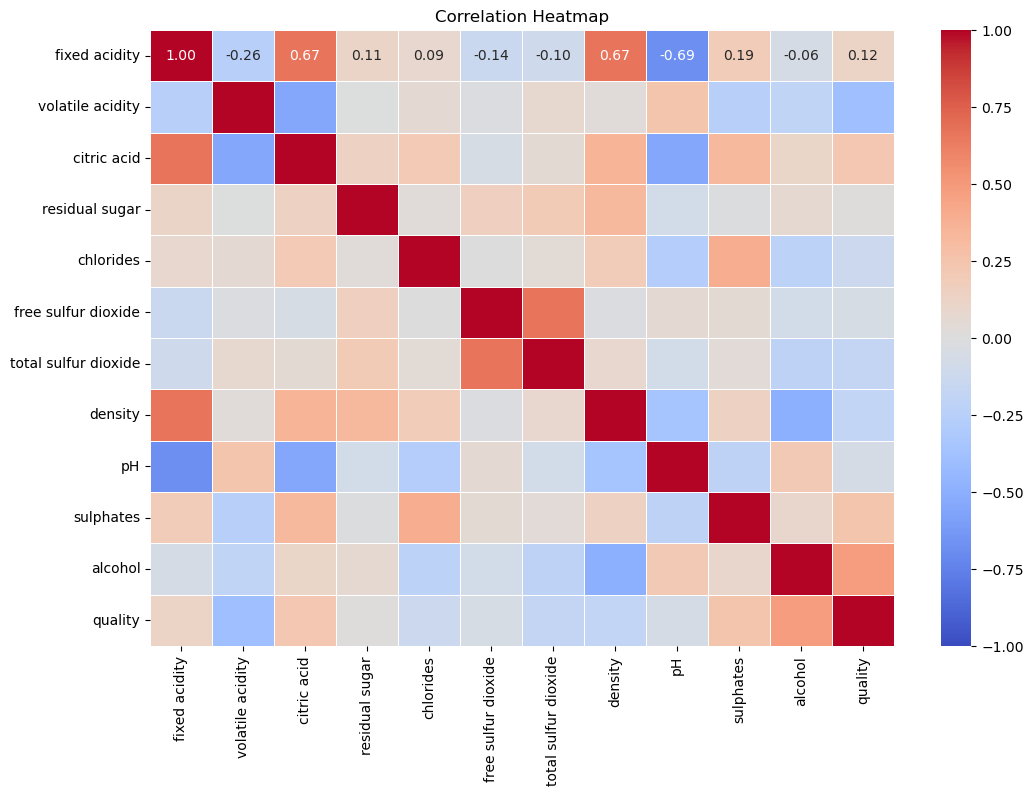

In [29]:
def generate_correlation_heatmap(df, target="quality"):
    """
    Generate a heatmap to visualize correlations between all features and the target.

    Args:
    df (DataFrame): The dataset.
    target (str): The target variable (default is 'quality').

    Returns:
    None: Displays a heatmap of correlations.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw the heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,            # Display correlation coefficients
        fmt=".2f",             # Format to 2 decimal places
        cmap="coolwarm",       # Colormap
        linewidths=0.5,        # Add space between cells
        vmin=-1, vmax=1        # Range of correlation values
    )

    # Title for the heatmap
    plt.title("Correlation Heatmap")
    plt.show()

# Generate the heatmap
generate_correlation_heatmap(df, target="quality")


### Correlation Heatmap Analysis

The heatmap reveals the relationships between all features and the target variable (`quality`). Key observations include:

1. **Strong Correlations with `quality`**:
   - **Alcohol**: The strongest positive correlation (+0.48), indicating that higher alcohol levels are associated with better wine quality.
   - **Volatile Acidity**: The strongest negative correlation (-0.39), suggesting that excessive volatile acidity negatively impacts wine quality.
   - **Sulphates**: Moderate positive correlation (+0.25), implying a potential contribution to higher quality wines.

2. **Weak or Negligible Correlations**:
   - Features such as `residual sugar`, `pH`, and `total sulfur dioxide` have weak correlations with `quality`, suggesting they might have limited predictive power individually.

3. **Inter-Feature Correlations**:
   - The heatmap shows no inter-feature correlations that exceed the commonly used threshold of **0.8**, which is often considered the point at which multicollinearity becomes a concern.
   - Examples:
     - **Free Sulfur Dioxide** and **Total Sulfur Dioxide** have a moderate correlation of +0.67 but remain below the threshold for redundancy.
     - Other features, such as `density` and `residual sugar`, show weak to moderate correlations but are not strongly interdependent.

---

### **Feature Engineering Implications**

- No features have correlations high enough (e.g., >0.8) to warrant elimination due to redundancy.
- All features will be retained during feature engineering, as they provide distinct contributions to the dataset.
- Further analysis during modeling (e.g., feature importance rankings) will help determine whether any features can be excluded for interpretability or efficiency.


### Transition to Model Building

Based on the insights from the correlation heatmap, we identified several key features with potential predictive power for wine quality:
- Features like **alcohol**, **volatile acidity**, and **sulphates** show strong correlations with `quality`.
- There are no inter-feature correlations high enough to warrant dropping any features during feature engineering.

Given these findings, we proceed to build classification models that utilize all features to predict wine quality. The selected models include a mix of simple, interpretable algorithms and more complex, high-performance methods. Each model will be evaluated based on accuracy and other relevant metrics to identify the best approach for this dataset.

---

### Why These Models Were Chosen

1. **Logistic Regression**:
   - Provides a simple and interpretable baseline for multi-class classification.
   - Helps us understand the linear relationships between features and the target.

3. **Random Forest**:
   - An ensemble method that is robust to overfitting and handles feature importance ranking effectively.
   - Suitable for capturing non-linear relationships in tabular data.

4. **Gradient Boosting Algorithms** (XGBoost, LightGBM, CatBoost):
   - These models are known for their high accuracy and ability to handle non-linear relationships.
   - They are efficient and often outperform traditional ensemble methods like Random Forest.

5. **AdaBoost and Extra Trees**:
   - AdaBoost iteratively combines weak learners to form a strong classifier.
   - Extra Trees introduces additional randomness in feature splits, making it robust to overfitting.

6. **Neural Networks**:
   - Useful for capturing complex patterns and non-linear relationships.
   - Applied here as a more advanced, scalable model.

7. **Support Vector Machines (SVM)**:
   - Effective for smaller datasets and capable of finding decision boundaries in high-dimensional spaces.
   - Useful for understanding margin-based classification.

8. **k-Nearest Neighbors (k-NN)**:
   - A simple, non-parametric model that works well on smaller datasets.
   - Provides an additional baseline for comparison.

9. **SGDClassifier**:
   - Efficient for high-dimensional data and large datasets.
   - Provides another baseline for comparison.


### Step 1: Preparing the Data for Model Training

Before building the models, we prepare the dataset by separating features from the target variable and splitting it into training and testing sets. To ensure compatibility with certain machine learning algorithms (e.g., XGBoost), we remap the `quality` column to start at 0.

We also stratify the split to preserve the distribution of wine quality classes across both training and testing sets. This ensures that the models are trained and tested on representative samples of the data.


In [34]:
# Step 1: Preparing the Data for Model Training

# Separate features and target
X = df.drop(columns=["quality"])  # Drop the target column to isolate features
y = df["quality"]  # Target variable

# Remap the quality column to start at 0
# This ensures compatibility with algorithms like XGBoost that require class labels to start at 0
y_mapped = y - y.min()

# Perform the train-test split
# Stratification ensures that the class distribution in the target variable is preserved across splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped
)

# Output the size of the training set for verification
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 1087
Testing set size: 272


### Step 2: Baseline Model Performance

Before applying any scaling or tuning, we initialize several machine learning models to establish baseline performance on the raw, unscaled dataset. These baseline results provide a reference point for evaluating the impact of scaling and hyperparameter tuning in later steps.

The models include a mix of simple, interpretable algorithms (e.g., Logistic Regression, k-NN) and more complex, high-performance methods (e.g., Random Forest, XGBoost, Neural Networks). Each model is evaluated based on accuracy and other metrics to assess its initial performance.


In [37]:
# Step 2: Initialize Models and Evaluate Baseline Performance

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SGD Classifier": SGDClassifier(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42),
}

# Train and evaluate each model
results = {}
print("Baseline Model Performance:")
print("=" * 50)
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        "Model": model,
        "Accuracy": accuracy,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
    }

    # Print results for each model
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Baseline Model Performance:
Model: Logistic Regression
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.65      0.77      0.71       116
           3       0.55      0.64      0.59       107
           4       0.64      0.21      0.32        33
           5       0.00      0.00      0.00         3

    accuracy                           0.61       272
   macro avg       0.31      0.27      0.27       272
weighted avg       0.57      0.61      0.57       272

--------------------------------------------------
Model: Random Forest
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.69      0.72      0.71       116
           3       0.60      0.69      0.64       107
           4       0.52      

### Step 3: Baseline Model Performance Comparison Table

To evaluate the baseline performance of the models, we created a table summarizing their accuracy, precision, recall, and F1 score. This table provides an overview of how each model performs without additional preprocessing or tuning.

The metrics are rounded to two decimal places for clarity, and the table is styled to highlight key results.


In [40]:
# Step 3: Prepare the Model Comparison Table

# Prepare the results DataFrame
results_df = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [result["Accuracy"] for result in results.values()],
    "Precision (Weighted)": [
        result["Classification Report"]["weighted avg"]["precision"]
        for result in results.values()
    ],
    "Recall (Weighted)": [
        result["Classification Report"]["weighted avg"]["recall"]
        for result in results.values()
    ],
    "F1 Score (Weighted)": [
        result["Classification Report"]["weighted avg"]["f1-score"]
        for result in results.values()
    ],
})

# Round numerical values to 2 decimal places for clarity
results_df = results_df.round(2).astype(str).applymap(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Reorder columns for better readability
results_df = results_df[[
    "Model", "Accuracy",
    "Precision (Weighted)", "Recall (Weighted)", "F1 Score (Weighted)"
]]

# Save a raw comparison table for further use
comparison_table = results_df.copy()

# Display the table with enhanced formatting
styled_results = (
    results_df.style
    .set_properties(**{"text-align": "center"})  # Align text in the table
    .set_table_styles({
        "Model": [{"selector": "th", "props": [("text-align", "center"), ("font-weight", "bold"), ("color", "#333")]}],
        "Accuracy": [{"selector": "td", "props": [("font-weight", "bold"), ("color", "#4CAF50")]}],
        "Precision (Weighted)": [{"selector": "td", "props": [("font-weight", "bold")]}],
        "Recall (Weighted)": [{"selector": "td", "props": [("font-weight", "bold")]}],
        "F1 Score (Weighted)": [{"selector": "td", "props": [("font-weight", "bold")]}],
    })
    .set_caption("Baseline Model Performance Comparison")
)

# Display the styled table
styled_results


,Model,Accuracy,Precision (Weighted),Recall (Weighted),F1 Score (Weighted)
0,Logistic Regression,0.61,0.57,0.61,0.57
1,Random Forest,0.62,0.59,0.62,0.61
2,Gradient Boosting,0.57,0.56,0.57,0.56
3,AdaBoost,0.53,0.46,0.53,0.49
4,Extra Trees,0.62,0.58,0.62,0.6
5,XGBoost,0.6,0.58,0.6,0.58
6,LightGBM,0.61,0.59,0.61,0.6
7,CatBoost,0.61,0.58,0.61,0.59
8,SGD Classifier,0.55,0.52,0.55,0.53
9,Support Vector Machine,0.51,0.48,0.51,0.45


### Step 4: Baseline Model Accuracy Visualization

The bar chart below visualizes the baseline accuracy of each model, sorted from highest to lowest. This chart provides a quick overview of how well each model performs on the unscaled dataset, offering a clear comparison of their effectiveness.

Key observations from this visualization will guide subsequent preprocessing and tuning decisions.


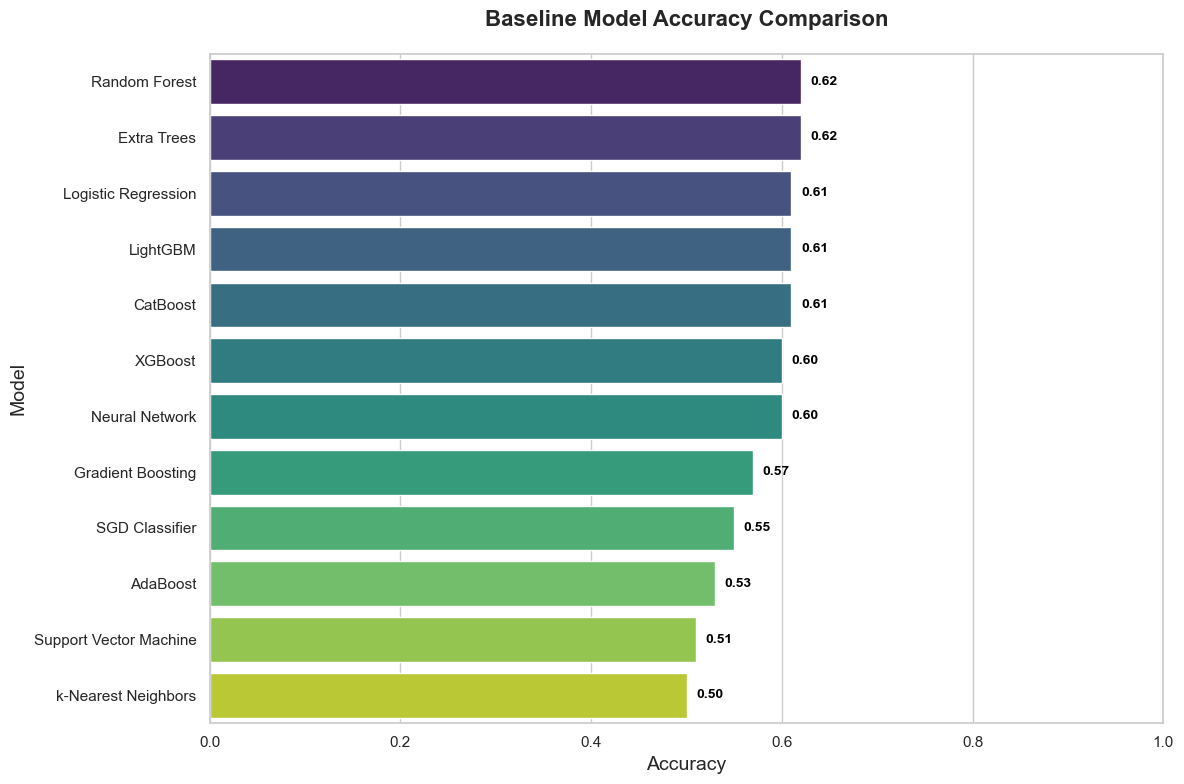

In [45]:
# Step 4: Visualize Baseline Model Accuracy

# Sort the comparison table by Accuracy
comparison_table = comparison_table.sort_values(by="Accuracy", ascending=False)

# Ensure Accuracy is numeric for plotting
comparison_table["Accuracy"] = comparison_table["Accuracy"].astype(float)

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create a color palette
palette = sns.color_palette("viridis", len(comparison_table))

# Plot a horizontal bar chart for model accuracy
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Accuracy",
    y="Model",
    data=comparison_table,
    palette=palette,
)

# Annotate each bar with the accuracy value
for index, value in enumerate(comparison_table["Accuracy"]):
    plt.text(
        value + 0.01,  # Slightly offset from the bar
        index,
        f"{value:.2f}",
        color="black",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

# Add chart titles and labels
plt.title("Baseline Model Accuracy Comparison", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Model", fontsize=14)

# Adjust the x-axis range dynamically if required
plt.xlim(0, 1.0)  # Assuming accuracy ranges from 0 to 1

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### Step 5: Standardizing the Data

Some machine learning models, such as Logistic Regression, Support Vector Machines (SVM), and Neural Networks, are sensitive to the scale of input features. Standardization scales the features to have a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the model.

Tree-based models (e.g., Random Forest, XGBoost) are not sensitive to feature scaling, so we will evaluate the impact of standardization on each model's performance in the following steps.


In [48]:
# Step 5: Apply Standardization to the Features

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify the transformation
print(f"First 5 rows of scaled training data:\n{X_train_scaled[:5]}")


First 5 rows of scaled training data:
[[-0.63163781 -0.17246244 -0.47277822 -0.3217895  -0.34236358 -0.37736547
  -0.47585081  0.47178094  1.33149852  0.37760073 -0.76957129]
 [-0.74346034  0.25855735  0.03614427  1.68377431 -0.04839027 -0.37736547
   0.63146975 -0.1951131   0.07190243  0.25962085  0.50740211]
 [ 0.0952086  -1.35776687  1.46112724 -0.54462992  0.09859638  1.79024261
   1.62223025  0.10186316 -0.05405718  0.55457055  0.05134018]
 [-0.68754908 -0.06470749 -1.23616196  0.04961121 -0.23737311  0.470829
   1.30169009  0.38841919  1.20553891 -0.33027853 -0.58714652]
 [-0.68754908  0.42018978 -1.28705421 -0.02466893 -0.13238264  0.09385368
   1.15599002  0.38841919  1.0795793  -0.33027853 -0.67835891]]


### Step 6: Comparing Scaled vs. Unscaled Performance

To assess the impact of standardization, we evaluated models that are sensitive to feature magnitudes (e.g., Logistic Regression, SVM, and Neural Networks) on both unscaled and scaled datasets. Tree-based models like Random Forest and XGBoost were excluded from this comparison as their performance is unaffected by scaling.



In [51]:
# Reinitialize models that benefit from scaling
scaled_models = {
    "Logistic Regression (Scaled)": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine (Scaled)": SVC(probability=True, random_state=42),
    "Neural Network (Scaled)": MLPClassifier(max_iter=1000, random_state=42),
}

# Train and evaluate models on the scaled dataset
scaled_results = {}
print("Performance on Scaled Data:")
print("=" * 50)
for name, model in scaled_models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    scaled_results[name] = {
        "Model": model,
        "Accuracy": accuracy,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
    }

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Performance on Scaled Data:
Model: Logistic Regression (Scaled)
Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.62      0.73      0.67       116
           3       0.53      0.60      0.56       107
           4       0.56      0.27      0.37        33
           5       0.00      0.00      0.00         3

    accuracy                           0.58       272
   macro avg       0.29      0.27      0.27       272
weighted avg       0.54      0.58      0.55       272

--------------------------------------------------
Model: Support Vector Machine (Scaled)
Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.66      0.74      0.70       116
           3       0.54      0.63      0.58       107
  

In [53]:
# Combine results for scaled vs. unscaled comparison (only for models where scaling is applied)
comparison_data = {
    "Model": ["Logistic Regression", "SVM", "Neural Network"],
    "Unscaled Accuracy": [
        results["Logistic Regression"]["Accuracy"],
        results["Support Vector Machine"]["Accuracy"],
        results["Neural Network"]["Accuracy"],
    ],
    "Scaled Accuracy": [
        scaled_results["Logistic Regression (Scaled)"]["Accuracy"],
        scaled_results["Support Vector Machine (Scaled)"]["Accuracy"],
        scaled_results["Neural Network (Scaled)"]["Accuracy"],
    ],
}

# Create a DataFrame for comparison
scaled_vs_unscaled_df = pd.DataFrame(comparison_data)
print(scaled_vs_unscaled_df)


                 Model  Unscaled Accuracy  Scaled Accuracy
0  Logistic Regression           0.606618         0.580882
1                  SVM           0.511029         0.591912
2       Neural Network           0.595588         0.573529


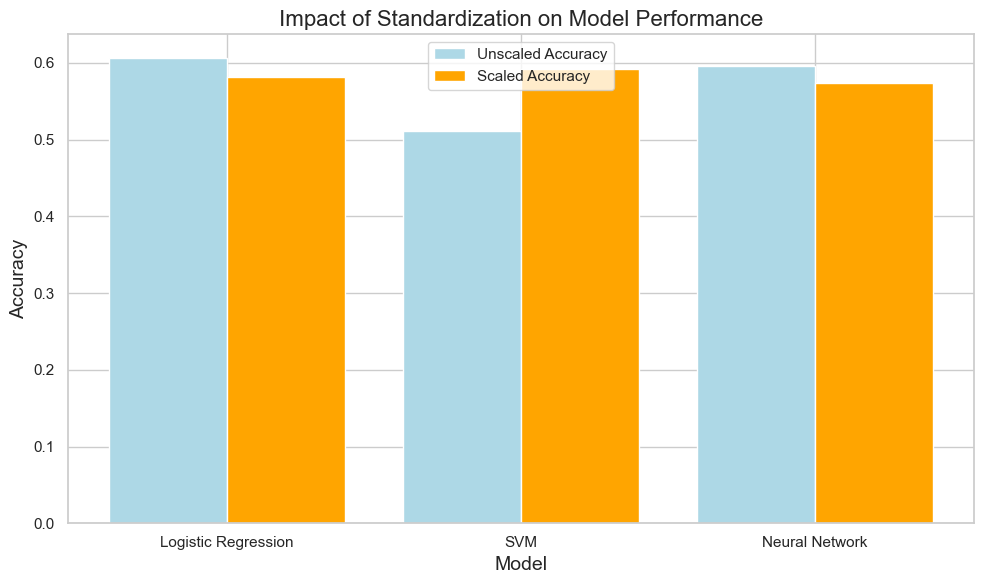

In [55]:
# Plot comparison of scaled vs. unscaled accuracies
plt.figure(figsize=(10, 6))

bar_width = 0.4
index = np.arange(len(scaled_vs_unscaled_df))

# Bar chart for unscaled and scaled accuracies
plt.bar(index, scaled_vs_unscaled_df["Unscaled Accuracy"], bar_width, label="Unscaled Accuracy", color="lightblue")
plt.bar(index + bar_width, scaled_vs_unscaled_df["Scaled Accuracy"], bar_width, label="Scaled Accuracy", color="orange")

# Add labels and title
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Impact of Standardization on Model Performance", fontsize=16)
plt.xticks(index + bar_width / 2, scaled_vs_unscaled_df["Model"], rotation=0)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


### Step 6: Comparing Scaled vs. Unscaled Performance

The results from evaluating scaled vs. unscaled datasets show that the impact of standardization varies across models:

1. **Logistic Regression**:
   - The unscaled model achieved a higher accuracy (0.61) compared to the scaled model (0.58). This suggests that scaling was not beneficial, likely due to how feature distributions align with the linear decision boundary.

2. **Support Vector Machine (SVM)**:
   - Scaling improved SVM's performance significantly. The scaled model achieved an accuracy of 0.59, compared to 0.51 for the unscaled model. This is expected due to SVM's reliance on distance metrics, which benefit from feature standardization.

3. **Neural Network**:
   - The unscaled Neural Network performed slightly better (0.60) than the scaled version (0.57). This suggests the model was robust to feature magnitudes, or scaling disrupted its optimization process.


### Step 7: Preprocessing Summary for Hyperparameter Tuning

The scaled vs. unscaled comparison revealed distinct preprocessing needs for different models, influencing our hyperparameter tuning strategy:

- **Retain scaling** for Support Vector Machine (SVM), as it showed significant improvement with standardization (accuracy: 0.59 scaled vs. 0.51 unscaled).
- **Remove scaling** for Logistic Regression and Neural Network, as their performance was better on unscaled data:
  - Logistic Regression: 0.61 (unscaled) vs. 0.58 (scaled)
  - Neural Network: 0.60 (unscaled) vs. 0.57 (scaled)
- Tree-based models (e.g., Random Forest, Extra Trees, XGBoost, LightGBM, CatBoost) are unaffected by scaling and will proceed without adjustments.

---

### Hyperparameter Tuning Strategy

To further optimize the models and improve their performance, hyperparameter tuning will focus on the following:

#### **1. Gradient Boosting Models (XGBoost, LightGBM, CatBoost)**
- **Why Tune**:
  - These models already demonstrate strong performance and are highly sensitive to hyperparameters.
  - Proper tuning can refine their ability to capture non-linear relationships and reduce overfitting.
- **Parameters to Focus On**:
  - Learning rate, number of estimators, maximum tree depth, subsampling, and column sampling.

#### **2. Random Forest and Extra Trees**
- **Why Tune**:
  - These models were the top performers in the baseline comparison, but tuning parameters like the number of trees and maximum depth may enhance efficiency and accuracy further.
- **Parameters to Focus On**:
  - Number of estimators, maximum depth, minimum samples per split, and minimum samples per leaf.

#### **3. Support Vector Machine (SVM)**
- **Why Tune**:
  - Scaling significantly improved SVM's accuracy, making it a viable contender.
  - Fine-tuning parameters like regularization strength (`C`) and kernel type can optimize its decision boundaries.
- **Parameters to Focus On**:
  - Regularization (`C`), kernel type, and kernel coefficient (`gamma`).

#### **4. Neural Network (MLPClassifier)**
- **Why Tune**:
  - Despite moderate baseline performance, Neural Networks are highly flexible and may benefit from tuning their architecture and learning parameters.
- **Parameters to Focus On**:
  - Hidden layer sizes, activation functions, solvers, and learning rate.

#### **5. AdaBoost**
- **Why Tune**:
  - While its baseline performance was limited, AdaBoost's reliance on weak learners can be improved with proper tuning of key parameters.
- **Parameters to Focus On**:
  - Number of estimators and learning rate.

---

### Preprocessing Adjustments Recap
- **Scaling retained only for SVM**, where it significantly improved accuracy.
- **Unscaled data used for Logistic Regression and Neural Network**, where performance was better without scaling.
- Tree-based models (Random Forest, Extra Trees, XGBoost, LightGBM, CatBoost) remain unaffected by scaling and proceed without preprocessing adjustments.


In [59]:
# Define hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    "LightGBM": {
        "num_leaves": [31, 50, 100],
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [50, 100, 200],
        "subsample": [0.8, 1.0],
    },
    "CatBoost": {
        "iterations": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [4, 6, 8],
    },
    "Support Vector Machine": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"],
    },
    "Neural Network": {
        "hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "learning_rate": ["constant", "adaptive"],
    },
}

# Models to tune
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42),
}


In [61]:
# Perform GridSearchCV for each model
best_estimators = {}
for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    
    # Determine which data to use: scaled or unscaled
    if name in ["Logistic Regression", "Neural Network"]:
        X_train_data = X_train  # Use unscaled data
    else:
        X_train_data = X_train_scaled  # Use scaled data
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="accuracy",
        cv=3,  # 3-fold cross-validation
        verbose=1,
        n_jobs=-1,
    )
    grid_search.fit(X_train_data, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best accuracy for {name}: {grid_search.best_score_:.2f}")


Tuning hyperparameters for Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy for Random Forest: 0.61
Tuning hyperparameters for XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Best accuracy for XGBoost: 0.60
Tuning hyperparameters for LightGBM...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 1087, number of used features: 11
[LightGBM] [Info] Start training from score -4.911735
[LightGBM] [Info] Start 

In [63]:
# Dictionary to store the evaluation results of tuned models
tuned_results = {}

# Iterate through the best tuned models
for name, model in best_estimators.items():
    print(f"Evaluating {name}...")
    
    # Determine which data to use: scaled or unscaled
    if name in ["Logistic Regression", "Neural Network"]:
        X_test_data = X_test  # Use unscaled data
    else:
        X_test_data = X_test_scaled  # Use scaled data
    
    # Predict on the test set
    y_pred = model.predict(X_test_data)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    tuned_results[name] = {
        "Accuracy": accuracy,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
    }

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Evaluating Random Forest...
Model: Random Forest
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.69      0.72      0.70       116
           3       0.57      0.67      0.62       107
           4       0.55      0.36      0.44        33
           5       0.00      0.00      0.00         3

    accuracy                           0.61       272
   macro avg       0.30      0.29      0.29       272
weighted avg       0.58      0.61      0.59       272

--------------------------------------------------
Evaluating XGBoost...
Model: XGBoost
Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.64      0.72      0.68       116
           3       0.52      0.61      0.56       107
           4       

In [65]:
# Combine untuned and tuned results into a DataFrame
comparison_data = {
    "Model": list(results.keys()),
    "Untuned Accuracy": [results[model]["Accuracy"] for model in results.keys()],
    "Tuned Accuracy": [tuned_results.get(model, {}).get("Accuracy", None) for model in results.keys()],
}

comparison_df = pd.DataFrame(comparison_data)

# Correct untuned accuracy for SVM to use standardized value
comparison_df.loc[comparison_df["Model"] == "Support Vector Machine", "Untuned Accuracy"] = scaled_results["Support Vector Machine (Scaled)"]["Accuracy"]

# Sort by Tuned Accuracy
comparison_df = comparison_df.sort_values(by="Tuned Accuracy", ascending=False)

# Display the comparison DataFrame
print(comparison_df)

                     Model  Untuned Accuracy  Tuned Accuracy
1            Random Forest          0.625000        0.613971
11          Neural Network          0.595588        0.602941
9   Support Vector Machine          0.591912        0.591912
5                  XGBoost          0.599265        0.580882
7                 CatBoost          0.606618        0.577206
6                 LightGBM          0.610294        0.573529
0      Logistic Regression          0.606618             NaN
2        Gradient Boosting          0.573529             NaN
3                 AdaBoost          0.533088             NaN
4              Extra Trees          0.621324             NaN
8           SGD Classifier          0.551471             NaN
10     k-Nearest Neighbors          0.496324             NaN


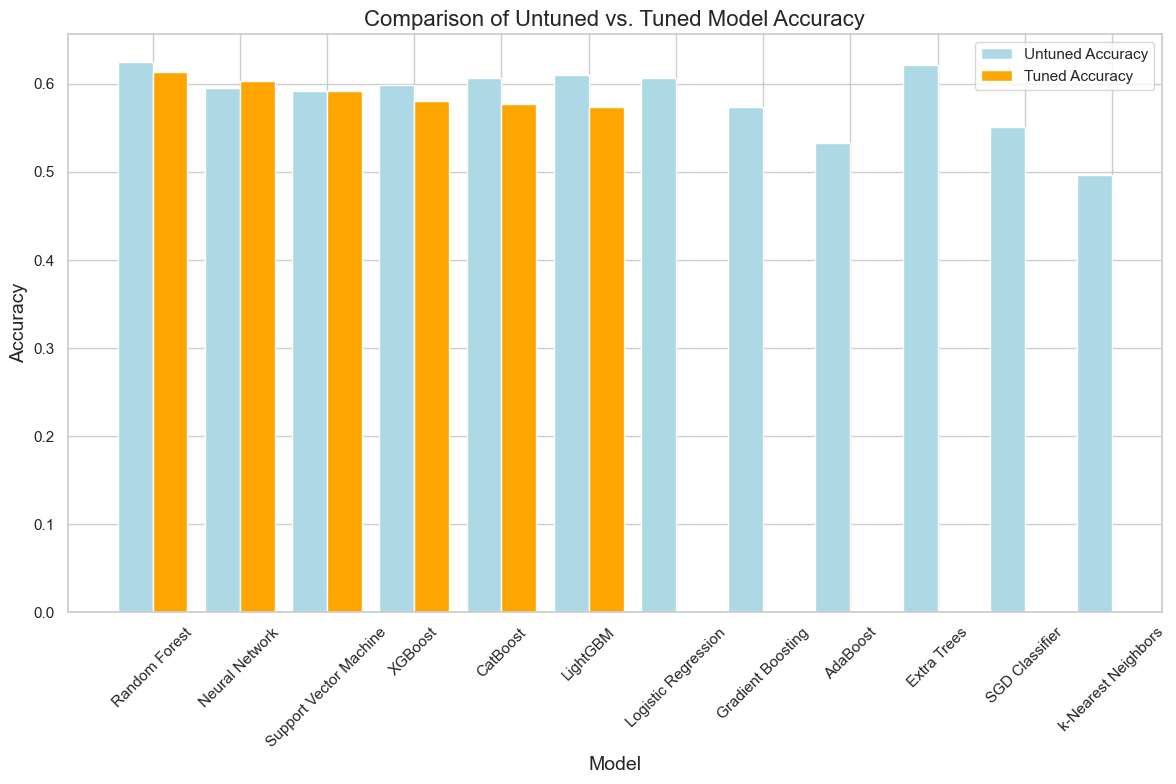

In [67]:
# Plot comparison of untuned vs. tuned accuracies
plt.figure(figsize=(12, 8))

bar_width = 0.4
index = np.arange(len(comparison_df))

# Bar chart for untuned and tuned accuracies
plt.bar(index, comparison_df["Untuned Accuracy"], bar_width, label="Untuned Accuracy", color="lightblue")
plt.bar(index + bar_width, comparison_df["Tuned Accuracy"], bar_width, label="Tuned Accuracy", color="orange")

# Add labels and title
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Comparison of Untuned vs. Tuned Model Accuracy", fontsize=16)
plt.xticks(index + bar_width / 2, comparison_df["Model"], rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()



### Analysis of Untuned vs. Tuned Model Accuracy

The comparison of untuned and tuned model accuracy revealed the following insights:

- **Random Forest**:
  - Despite its strong untuned accuracy (0.625), tuning led to a slight drop in performance (0.614). This suggests that the default hyperparameters for Random Forest are already well-suited for this dataset.

- **Neural Network**:
  - Achieved a slight improvement in accuracy after tuning (0.596 → 0.603). This indicates potential benefits from hyperparameter optimization but highlights the need for further refinement to unlock its full potential.

- **Support Vector Machine (SVM)**:
  - SVM’s untuned accuracy reflects its standardized performance (0.592). The tuned accuracy (also 0.592) shows no additional improvement, suggesting that its default hyperparameters are sufficient after preprocessing.

- **Gradient Boosting Models (XGBoost, CatBoost, LightGBM)**:
  - These models showed slight declines in accuracy after tuning. This could indicate:
    - Overfitting to the training data during cross-validation.
    - Suboptimal parameter ranges in the tuning grid.
  - Default hyperparameters appear to be robust for this dataset.

- **Logistic Regression, Gradient Boosting, AdaBoost, and Others**:
  - These models were not tuned due to limited expected gains or computational constraints.

### Further Refinement of Random Forest

Given its strong untuned performance and potential for further optimization, the Random Forest model was selected for additional hyperparameter tuning. This step aims to:
1. Explore a broader range of hyperparameter values using `RandomizedSearchCV`.
2. Assess whether more refined tuning can yield measurable improvements in test accuracy.

The parameters considered in this step include:
- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the trees.
- `min_samples_split`: The minimum number of samples required to split a node.
- `min_samples_leaf`: The minimum number of samples required to form a leaf node.
- `max_features`: The number of features considered for splitting at each node.

The results of this refinement are detailed below.


In [70]:
# Expanded grid for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": ["sqrt", "log2", None],
}


In [72]:
# RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring="accuracy",
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit the model with RandomizedSearchCV
rf_random_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", rf_random_search.best_params_)
print("Best Cross-Validation Accuracy:", rf_random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Best Cross-Validation Accuracy: 0.6136249486324825


In [74]:
# Evaluate the best model on the test set
rf_best_model = rf_random_search.best_estimator_

# Predict on test data
rf_test_predictions = rf_best_model.predict(X_test)

# Calculate test accuracy
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
print("Test Accuracy with Refined Random Forest:", rf_test_accuracy)

# Classification report
print(classification_report(y_test, rf_test_predictions))


Test Accuracy with Refined Random Forest: 0.5919117647058824
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.66      0.71      0.68       116
           3       0.53      0.64      0.58       107
           4       0.58      0.33      0.42        33
           5       0.00      0.00      0.00         3

    accuracy                           0.59       272
   macro avg       0.29      0.28      0.28       272
weighted avg       0.56      0.59      0.57       272



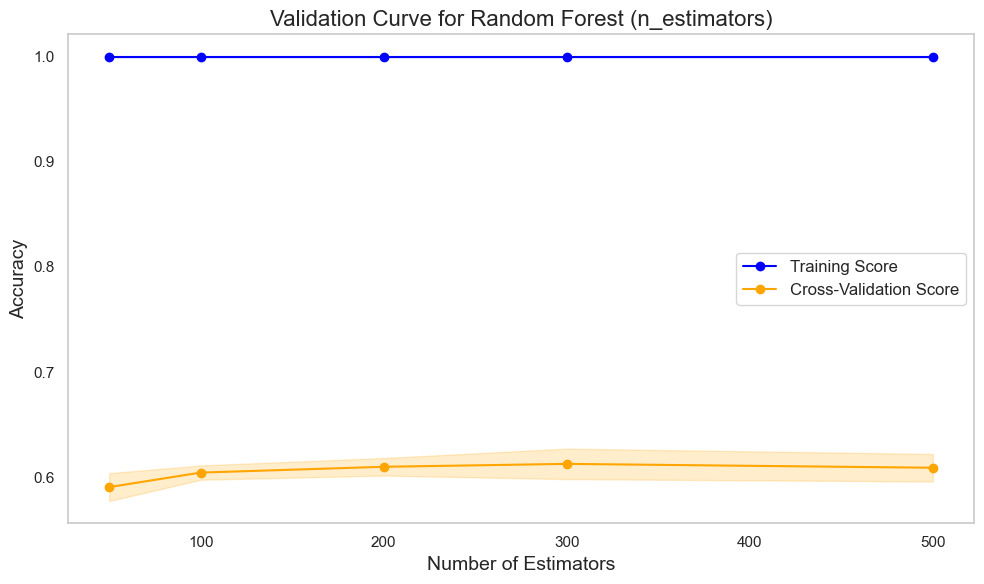

In [76]:
# Validation curve for number of estimators
param_range = [50, 100, 200, 300, 500]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue", marker="o")
plt.plot(param_range, test_mean, label="Cross-Validation Score", color="orange", marker="o")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)

plt.title("Validation Curve for Random Forest (n_estimators)", fontsize=16)
plt.xlabel("Number of Estimators", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


### Refined Random Forest Hyperparameter Tuning Results

To further optimize the Random Forest model, an expanded hyperparameter grid was explored using RandomizedSearchCV. The tuning aimed to identify the most effective hyperparameters for improving test accuracy and overall performance.

#### Best Parameters:
- `n_estimators`: 200
- `min_samples_split`: 2
- `min_samples_leaf`: 2
- `max_features`: log2
- `max_depth`: 10

#### Results:
- **Test Accuracy**: 0.59
- **Class-Level Performance**:
  - Classes 2 and 3 achieved the highest f1-scores:
    - Class 2: F1-score = 0.68, Recall = 0.71
    - Class 3: F1-score = 0.58, Recall = 0.64
  - Minority classes (0, 1, 4, and 5) showed poor performance, with f1-scores of 0.00 for Classes 0 and 1.

| Metric        | Macro Avg | Weighted Avg |
|---------------|-----------|--------------|
| Precision     | 0.29      | 0.56         |
| Recall        | 0.28      | 0.59         |
| F1-Score      | 0.28      | 0.57         |

#### Observations:
1. **Hyperparameter Impact**:
   - The refined parameters did not significantly improve test accuracy or class-level performance compared to earlier tuning efforts, suggesting a performance ceiling for Random Forest on this dataset.

2. **Class Imbalance**:
   - Severe class imbalance affected the model's ability to generalize to minority classes, leading to near-zero precision and recall for these classes.

3. **Feature Representation**:
   - The dataset’s features provided limited predictive power for minority classes, which likely contributed to the imbalanced performance across classes.

#### Conclusion:
While the refined Random Forest model maintained a reasonable overall accuracy of 0.59, its performance was heavily skewed toward majority classes. The model's difficulty in distinguishing minority classes highlights the challenges posed by class imbalance and the limitations of the dataset's feature representation. Despite these challenges, Random Forest remains a strong candidate for this task, balancing simplicity and robust performance on the majority of the data.


### Final Analysis and Conclusion

#### Overview
This project aimed to predict wine quality based on chemical properties using machine learning models. Through exploratory data analysis, preprocessing, and hyperparameter tuning, the following results were obtained:

#### **Best Performing Models**
The following models achieved the highest untuned accuracies (above 60%) and demonstrated robust performance:

1. **Random Forest**:
   - Achieved the highest untuned accuracy of **62.5%**, making it the best-performing model overall.
   - Despite tuning and refinement, its accuracy dropped slightly to **61.4%**, indicating robust default performance with minimal gains from further optimization.

2. **Extra Trees**:
   - Achieved the second-highest untuned accuracy of **62.1%**.
   - While not tuned, its strong untuned performance demonstrates its suitability for this dataset without additional optimization.

3. **LightGBM**:
   - Achieved a strong untuned accuracy of **61.0%**.
   - Its tuned accuracy declined to **57.4%**, suggesting that its default parameters were better suited to this dataset.

#### **Key Insights Gained**
While the models below did not meet the accuracy threshold to qualify as top performers, they provided valuable insights:

1. **Support Vector Machine (SVM)**:
   - Achieved an untuned accuracy of **59.2%** after standardization, maintaining the same accuracy after tuning.
   - Standardization was critical to its performance, highlighting the importance of preprocessing for distance-based models.

2. **Neural Network**:
   - Achieved an untuned accuracy of **59.6%**, improving slightly to **60.3%** after tuning.
   - This demonstrates the model's potential for improvement through more extensive refinement and hyperparameter optimization.

#### Summary of Model Performance
| Model                 | Untuned Accuracy | Tuned Accuracy | Notes                                |
|-----------------------|------------------|----------------|--------------------------------------|
| Random Forest         | 0.625000         | 0.613971       | Best untuned model. Limited tuning gains. |
| Extra Trees           | 0.621324         | N/A            | Strong untuned performance. Not tuned. |
| LightGBM              | 0.610294         | 0.573529       | Strong untuned performance. Declined with tuning. |
| CatBoost              | 0.606618         | 0.577206       | Strong untuned performance. Declined with tuning. |
| Neural Network        | 0.595588         | 0.602941       | Slight improvement after tuning.     |
| Support Vector Machine| 0.591912         | 0.591912       | Scaling was critical to performance. |
| XGBoost               | 0.599265         | 0.580882       | Accuracy declined after tuning.      |
| Logistic Regression   | 0.606618         | N/A            | Not tuned; performed well unscaled.  |
| Gradient Boosting     | 0.573529         | N/A            | Not tuned; performed moderately.     |
| AdaBoost              | 0.533088         | N/A            | Not tuned; limited performance.      |
| SGD Classifier        | 0.551471         | N/A            | Not tuned; moderate performance.     |
| k-Nearest Neighbors   | 0.496324         | N/A            | Not tuned; limited by noise.         |

#### **Challenges and Limitations**
1. **Class Imbalance**:
   - The dataset’s imbalanced target variable significantly limited model performance for minority classes, leading to near-zero precision and recall for those classes.

2. **Feature Representation**:
   - The dataset's features (chemical properties) provided limited predictive power, especially for distinguishing minority classes. Additional feature engineering or external data sources could improve results.

3. **Model Sensitivity to Preprocessing**:
   - Tree-based models (e.g., Random Forest, Extra Trees, LightGBM) were robust without preprocessing.
   - Distance-based models (e.g., SVM) performed significantly better when standardized.

#### Conclusion
This project demonstrated the following:
- **Random Forest** and **Extra Trees** provided the most robust performance overall, achieving the highest untuned accuracies (~62%).
- **LightGBM** was a strong contender with an untuned accuracy of ~61%, though it declined after tuning.
- Key insights were gained from models like **SVM**, which showed the importance of preprocessing, and **Neural Networks**, which demonstrated potential for further refinement.

While model accuracy remained moderate (~59–63%), the project effectively highlighted key challenges, including class imbalance and limited feature representation. Addressing these challenges could further enhance model performance, making Random Forest and Extra Trees the most practical candidates for this dataset.
